In [327]:
import pandas as pd
import scipy.sparse as sp
from scipy import linalg
import numpy as np
import time
from pandas import DataFrame
import csv
import json
import re
import regex
import seaborn as sns
from collections import Counter
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from datetime import datetime
from dateutil import tz

import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import spacy
from spacy.tokens import Doc
#from spacy.en import English

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk_words = set(nltk.corpus.words.words())
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")

from gensim import corpora, models, similarities
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from gensim.models import LdaModel

import pyLDAvis 
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

## Read & Prepare Data

In [2]:
#file = pd.read_pickle("RS_2018-09.xz",compression='infer')
# import lzma
# with open("RS_2018-09.xz", encoding='utf-8') as compressed:
#     with lzma.LZMAFile(compressed) as uncompressed:
#         for line in uncompressed:
#             print(line)

In [3]:
# with open("RS_2018-09") as txtfile:
#     data = json.loads(txtfile)
#     for line in data:
#         print(line)
#         break

In [4]:
# code from:
# https://stackoverflow.com/questions/35159967/setting-google-application-credentials-for-bigquery-python-cli
# https://stackoverflow.com/questions/42555142/downloading-a-file-from-google-cloud-storage-inside-a-folder
# https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56014


# from google.cloud import storage

# from io import BytesIO

# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/zimmer/Documents/SI_671/zimmerja_671_project/Zimmerja-671-project-e5fa2b1d8041.json"

# Initialise a client
# storage_client = storage.Client("Zimmerja-671-project-222514")
# # Create a bucket object for our bucket
# bucket_name = 'zimmerja_671'
# bucket = storage_client.get_bucket(bucket_name)
# # Create a blob object from the filepath
# blob = bucket.blob("ama_comment_data")
# # Download the file to a destination
# blob.download_to_filename('ama_comment_data_sept.csv')



In [5]:
# blob = bucket.blob("science_comment_data")
# # Download the file to a destination
# blob.download_to_filename('science_comment_data_sept.csv')

In [6]:
# blob = bucket.blob("pokemon_comment_data")
# # Download the file to a destination
# blob.download_to_filename('pokemon_comment_data_sept.csv')

### r/IAmA

In [7]:
ama_posts = pd.read_csv("ama_post_data_sept.csv")

In [8]:
#ama_posts.head()

In [9]:
ama_posts_clean = ama_posts[['created_utc', 'subreddit', 'author', 'num_comments', 'score', 'title', 'selftext', 'id', 'gilded', 'subreddit_id']]
#ama_posts_clean[ama_posts_clean['id'] == '9ee0s9']

In [10]:
ama_comments = pd.read_csv("ama_comment_data_sept.csv")
ama_comments_clean = ama_comments[['body', 'author', 'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'score', 'id', 'gilded', 'subreddit']]
#ama_comments_clean.head()

In [11]:
# Get sample of posts with all associated comments for analysis
# IAmA -> Top 5 posts = 37% of comments in dataset (Top 10 = 50%)
# Science -> Top 11 posts = 25% of comments in dataset
# Pokemon -> Top 46 posts = 25% of comments in dataset
ama_sample_post_ids = ['t3_9h5oi0', 't3_9ee0s9', 't3_9c4uly', 't3_9cyhq5', 't3_9ens3f'] #rest of Top 10 -> 't3_9i8460', 't3_9ijtbj', 't3_9cd77w', 't3_9hqi4x'
science_sample_post_ids = ['t3_9jj7z1','t3_9he1fn','t3_9jv6hs','t3_9fqrit','t3_9ihgph','t3_9j68tv','t3_9jem15','t3_9gor0n','t3_9emmr2','t3_9eslew','t3_9gu7x2']
poke_sample_post_ids = ['t3_9irxal','t3_9ckkzs','t3_9jn0ns','t3_9eldgz','t3_9hmriv','t3_9k2maa','t3_9igeoz','t3_9enb3y','t3_9gfa35','t3_9gt5sp','t3_9d9olz','t3_9cjzan','t3_9gkj5t','t3_9ierdv','t3_9f29cp','t3_9e7ps7','t3_9cm90k','t3_9c2tfs','t3_9c66wh','t3_9ch4l0','t3_9cb1t0','t3_9ie0oa','t3_9h4yxo','t3_9ehis8','t3_9jc4wa','t3_9i5lz0','t3_9gtxup','t3_9emyyi','t3_9hqedh','t3_9gyb7b','t3_9k455q','t3_9c0ku3','t3_9fqw1g','t3_9g7zwb','t3_9hvu9x','t3_9i8yjh','t3_9j2gfw','t3_9c5i54','t3_9jwijj','t3_9is4h2','t3_9jvf2d','t3_9hu7np','t3_9dvf5f','t3_9jkyou','t3_9ed6y9','t3_9hgvh6']

In [12]:
ama_comments_sample = ama_comments_clean[ama_comments_clean['link_id'].isin(ama_sample_post_ids)]

In [13]:
ama_comments_sample.shape

(32107, 10)

### r/Science

In [14]:
science_posts = pd.read_csv("science_post_data_sept.csv")

In [15]:
#science_posts.head()

In [16]:
science_posts_clean = science_posts[['created_utc', 'subreddit', 'author', 'num_comments', 'score', 'title', 'selftext', 'id', 'gilded', 'subreddit_id']]
#ama_posts_clean.head()

In [17]:
science_comments = pd.read_csv("science_comment_data_sept.csv")
science_comments_clean = science_comments[['body', 'author', 'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'score', 'id', 'gilded', 'subreddit']]
#science_comments_clean.head()

In [18]:
science_comments_sample = science_comments_clean[science_comments_clean['link_id'].isin(science_sample_post_ids)]

In [19]:
science_comments_sample.shape

(29376, 10)

### r/Pokemon

In [20]:
poke_posts = pd.read_csv("pokemon_post_data_sept.csv")

In [21]:
#poke_posts.head()

In [22]:
poke_posts_clean = poke_posts[['created_utc', 'subreddit', 'author', 'num_comments', 'score', 'title', 'selftext', 'id', 'gilded', 'subreddit_id']]
#poke_posts_clean.head()

In [23]:
poke_comments = pd.read_csv("pokemon_comment_data_sept.csv")
poke_comments_clean = poke_comments[['body', 'author', 'created_utc', 'subreddit_id', 'link_id', 'parent_id', 'score', 'id', 'gilded', 'subreddit']]
#poke_comments_clean.head()

In [24]:
poke_comments_sample = poke_comments_clean[poke_comments_clean['link_id'].isin(poke_sample_post_ids)]

In [25]:
poke_comments_sample.shape

(13975, 10)

# Preprocessing

## Create BOW for subreddit

In [26]:
#Create concatenated master string of all post submission titles, selftexts, and comment bodies in a subreddit
#   Removes URLS, [deleted], ['removed']
def create_subreddit_string(post_df, comment_df):
    
    temp_str = ''
    
    count=0
    stage_one = len(post_df) + len(comment_df)
    
    # Get Post data
    for index, row in post_df.iterrows():
        count = count + 1
        print('(POSTS): ', (count/stage_one)*100)
        title = str(row[5]).lower()
        body = str(row[6]).lower()

        #title
        #remove URL's for analysis
        title = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', title)
            
        title = regex.sub(r'^http[^' '\n]', '', title)

        if ((title == '[removed]') | (title == '[deleted]') | (title == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + title #title
        
        #body
        #remove URL's, deleted/removed posts for analysis
 
        body = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)

        body = regex.sub(r'^http[^' '\n]', '', body)

        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext
    
    # Get Comment data
    for index, row in comment_df.iterrows():
        count = count + 1
        print('(COMM): ', (count/stage_one)*100)
        comm = str(row[0]).lower()
        
        #remove URL's, deleted/removed comments for analysis
        
        comm = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', comm)
            
        comm = regex.sub(r'^http[^' '\n]', '', comm)
     
        if ((comm == '[removed]') | (comm == '[deleted]') | (title == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + comm #comment body
    
    temp_split = temp_str.split()
    
    #Remove stopwords, punctuation, non alphabetic characters, uninformative words
    stops = stopwords.words('english')
    newStopWords = ['AMA','[AMA Request]', 'IAmA', 'ama', '[Crosspost]', 'r/IAmA', '[x-post]', '[xpost]', '']
    stops.extend(newStopWords)
    
    final_str = ''
    
    stage_two = len(temp_split) + stage_one
    
    for word in temp_split:
        count = count + 1
        print('(TWO): ', (count/stage_two)*100)
        word = regex.sub(r"[\p{P}+]", "", word)
        word = regex.sub(r'\d+', '', word)
        if word.lower() in nltk_words or not word.isalpha():
            if word not in stops:
                final_str = final_str + ' ' + word
    
    return final_str

### r/IAmA

In [27]:
# #Create concatenated master string of all single-subreddit submission titles, selftexts
# ama_all = ''
# for index, row in ama_posts_clean.iterrows():
#     title = str(row[5]).lower()
#     body = str(row[6]).lower()
    
#     #remove URL's for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', title)):
#         title = regex.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', title)
#         continue
#     elif (re.findall('^http', title)):
#         title = regex.sub('^http[^' '\n]', '', title)
#         continue
#     elif ((title == '[removed]') | (title == '[deleted]')):
#         ama_all = ama_all
#     else:
#         ama_all = ama_all + ' ' + title #title
        
#     #remove URL's, deleted/removed posts for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', body)):
#         body = regex.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)
#         continue
#     elif (re.findall('^http[^' '\n]', body)):
#         body = regex.sub('^http[^' '\n]', '', body)
#         continue
#     elif ((body == '[removed]') | (body == '[deleted]')):
#         ama_all = ama_all
#     else:
#         ama_all = ama_all + ' ' + body #selftext


In [28]:
# #Concatenate strings of all sampled single-subreddit comment bodies to master string
# count = 0
# for index, row in ama_comments_sample.iterrows():
#     count = count + 1
#     print((count/32107)*100)
    
#     #remove URL's, deleted/removed comments for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', row[0])):
#         continue
#     elif (re.findall('^http', row[0])):
#         continue
#     elif ((str(row[0]) == '[removed]') | (str(row[0]) == '[deleted]')):
#         continue
#     else:
#         ama_all = ama_all + ' ' + str(row[0]).lower() #title

In [29]:
# ama_split = ama_all.split(' ')
# len(ama_split)

In [30]:
# #Remove punctuation
# nltk_words = set(nltk.corpus.words.words())
# punc = [",", "\'", ".", "!", "?", "(", ")", "+", "-", "_", "[", "]", "&", "/", "\\", "*", "@", "#", "$", "%", "^", "=", "{", "}", '"']
# ama_for_token = ''
# count2 = 0
# for word in ama_split:
#     count2 = count2 + 1
#     print((count2/1573858)*100)
#     word = regex.sub("[\p{P}+]", "", word)
#     word = regex.sub(r'\d+', '', word)

# #     temp = ''
# #     for char in word:
# #         char = re.sub('[0-9]', '', char)
# #         if (char in punc):
# #             char = ''
# #         temp = temp + char
# #     if temp != '':
# #         ama_for_token = ama_for_token + ' ' + temp
#     if word.lower() in nltk_words or not word.isalpha():
#         ama_for_token = ama_for_token + ' ' + word

In [31]:
# #Remove stopwords and various uninformative words

# stops = stopwords.words('english')
# newStopWords = ['AMA','[AMA Request]', 'IAmA', 'ama', '[Crosspost]', 'r/IAmA', '[x-post]', '[xpost]', '']
# stops.extend(newStopWords)
# filtered_ama_all = [word for word in ama_for_token.split(' ') if word not in stops]

In [32]:
# ama_final_str = ' '.join(filtered_ama_all)

In [33]:
# ama_final_str = create_subreddit_string(ama_posts_clean, ama_comments_sample)

In [34]:
# ama_final_str = ama_final_str.replace('\n', '')

In [35]:
# # Write string to text file for future
# text_file = open("ama_bow_string.txt", "w")
# text_file.write(ama_final_str)
# text_file.close()

In [36]:
# Open saved text file
ama_temp = open("ama_bow_string.txt", 'r')
ama_final_str = ''
for row in ama_temp:
    ama_final_str = ama_final_str + ' ' + row

In [37]:
filtered_ama_all = ama_final_str.split()
len(ama_final_str)

4210180

### r/Science

In [38]:
# #Create concatenated master string of all single-subreddit submission titles, selftexts
# science_all = ''
# for index, row in science_posts_clean.iterrows():
    
#     #remove URL's for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', row[5])):
#         continue
#     elif (re.findall('^http', row[5])):
#         continue
#     elif ((row[5] == '[removed]') | (row[5] == '[deleted]')):
#         science_all = science_all
#     else:
#         science_all = science_all + ' ' + str(row[5]).lower() #title
        
#     #remove URL's, deleted/removed posts for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(row[6]))):
#         continue
#     elif (re.findall('^http', row[5])):
#         continue
#     elif ((str(row[6]) == '[removed]') | (str(row[6]) == '[deleted]')):
#         science_all = science_all
#     else:
#         science_all = science_all + ' ' + str(row[6]).lower() #selftext

In [39]:
# #Concatenate strings of all sampled single-subreddit comment bodies to master string
# #count = 0
# for index, row in science_comments_sample.iterrows():
#     #count = count + 1
#     #print((count/32107)*100)
    
#     #remove URL's, deleted/removed comments for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', row[0])):
#         continue
#     elif (re.findall('^http', row[0])):
#         continue
#     elif ((str(row[0]) == '[removed]') | (str(row[0]) == '[deleted]')):
#         continue
#     else:
#         science_all = science_all + ' ' + str(row[0]).lower() #title

In [40]:
# science_split = science_all.split(' ')
# len(science_split)

In [41]:
# #Remove punctuation and non-alphabetic
# science_for_token = ''
# count2 = 0
# for word in science_split:
#     count2 = count2 + 1
#     print((count2/1573858)*100)
#     word = regex.sub("[\p{P}+]", "", word)
#     word = regex.sub(r'\d+', '', word)
#     if word.lower() in nltk_words or not word.isalpha():
#         science_for_token = science_for_token + ' ' + word

In [42]:
# science_for_token[:10000]

In [43]:
# #Remove stopwords and various uninformative words

# stops = stopwords.words('english')
# #newStopWords = ['AMA','[AMA Request]', 'IAmA', 'ama', '[Crosspost]', 'r/IAmA', '[x-post]', '[xpost]', '']
# #stops.extend(newStopWords)
# filtered_science_all = [word for word in science_for_token.split(' ') if word not in stops]

In [44]:
# science_final_str = ' '.join(filtered_science_all)

In [45]:
# science_final_str = create_subreddit_string(science_posts_clean, science_comments_sample)

In [46]:
# science_final_str = science_final_str.replace('\n', '')

In [47]:
# # Write string to text file for future
# text_file = open("science_bow_string.txt", "w")
# text_file.write(science_final_str)
# text_file.close()

In [48]:
# Open saved text file
science_temp = open("science_bow_string.txt", 'r')
science_final_str = ''
for row in science_temp:
    science_final_str = science_final_str + ' ' + row

In [49]:
filtered_science_all = science_final_str.split()
len(science_final_str)

1715982

### r/Pokemon

In [50]:
# #Create concatenated master string of all single-subreddit submission titles, selftexts
# poke_all = ''
# for index, row in poke_posts_clean.iterrows():
    
#     #remove URL's for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', row[5])):
#         continue
#     elif (re.findall('^http', row[5])):
#         continue
#     elif ((row[5] == '[removed]') | (row[5] == '[deleted]')):
#         poke_all = poke_all
#     else:
#         poke_all = poke_all + ' ' + str(row[5]).lower() #title
        
#     #remove URL's, deleted/removed posts for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(row[6]))):
#         continue
#     elif ((str(row[6]) == '[removed]') | (str(row[6]) == '[deleted]')):
#         poke_all = poke_all
#     else:
#         poke_all = poke_all + ' ' + str(row[6]).lower() #selftext

In [51]:
# #Concatenate strings of all sampled single-subreddit comment bodies to master string
# count = 0
# for index, row in poke_comments_sample.iterrows():
#     count = count + 1
#     print((count/32107)*100)
    
#     #remove URL's, deleted/removed comments for analysis
#     if (re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', row[0])):
#         continue
#     elif (re.findall('^http', row[0])):
#         continue
#     elif ((str(row[0]) == '[removed]') | (str(row[0]) == '[deleted]')):
#         continue
#     else:
#         poke_all = poke_all + ' ' + str(row[0]).lower() #title

In [52]:
# poke_split = poke_all.split(' ')
# len(poke_split)

In [53]:
# #Remove punctuation and non alphabetic characters
# poke_for_token = ''
# count2 = 0
# for word in poke_split:
#     count2 = count2 + 1
#     print((count2/1573858)*100)
#     word = regex.sub("[\p{P}+]", "", word)
#     word = regex.sub(r'\d+', '', word)
#     if word.lower() in nltk_words or not word.isalpha():
#         poke_for_token = poke_for_token + ' ' + word

In [54]:
# #Remove stopwords and various uninformative words

# stops = stopwords.words('english')
# #newStopWords = ['AMA','[AMA Request]', 'IAmA', 'ama', '[Crosspost]', 'r/IAmA', '[x-post]', '[xpost]', '']
# #stops.extend(newStopWords)
# filtered_poke_all = [word for word in poke_for_token.split(' ') if word not in stops]

In [55]:
# poke_final_str = ' '.join(filtered_poke_all)

In [56]:
# poke_final_str = create_subreddit_string(poke_posts_clean, poke_comments_sample)

In [57]:
# poke_final_str = poke_final_str.replace('\n', '')

In [58]:
# # Write string to text file for future
# text_file = open("pokemon_bow_string.txt", "w")
# text_file.write(poke_final_str)
# text_file.close()

In [59]:
# Open saved text file
poke_temp = open("pokemon_bow_string.txt", 'r')
poke_final_str = ''
for row in poke_temp:
    poke_final_str = poke_final_str + ' ' + row

In [60]:
filtered_poke_all = poke_final_str.split()
len(poke_final_str)

1146717

### SpaCy and Gensim Trials

In [61]:
# nlp = spacy.load("en_core_web_lg")

In [62]:
# #http://dsgeek.com/2018/02/19/tfidf_vectors.html
# def keep_token(t):
#     return (t.is_alpha and 
#             not (t.is_space or t.is_punct or 
#                  t.is_stop or t.like_num))

# def lemmatize_doc(doc):
#     return [ t.lemma_ for t in doc if keep_token(t)]

In [63]:
# docs = [ama_final_str, science_final_str, poke_final_str]

In [64]:
#Lemmatize data
# lem = [lemmatize_doc(nlp(doc[:999999])) for doc in docs]

In [65]:
# # Create dictionary
# docs_dict = Dictionary(lem)
# #docs_dict.compactify()

In [66]:
# #Create BOWs for each subreddit
# docs_corpus = [docs_dict.doc2bow(doc) for doc in lem]
# model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
# docs_tfidf  = model_tfidf[docs_corpus]
# docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [67]:
# # docs_vecs[0] = IAmA
# # docs_vecs[1] = Science
# # docs_vecs[2] = Pokemon

# docs_vecs[0]

In [68]:
# wc = [nlp(doc[:999999]) for doc in docs]

### 1. Relevance Scoring

#### 1.1  |  Whole-subreddit pre-processing
- Create Bag of Words representations from each subreddit's entire sample set
- Get each subreddit's keywords
- LDA Topic modeling on each subreddit BOW
- Get Top 10 topics per subreddit, and the 10 most related tokens to that topic

##### 1.1.1 Subreddit Keywords
 - Get create Bag of Words model for entire subreddit using tf-idf measure
 - Find Top 15 keywords for each subreddit according to tf-idf

In [69]:
# AMA BOW Model
tf_vectorizer = TfidfVectorizer() # tf-idf measure
#tf_vectorizer = CountVectorizer() # raw count
tf_ama = tf_vectorizer.fit_transform(filtered_ama_all)
ama_features = tf_vectorizer.get_feature_names()

In [70]:
# Get Keywords for r/IAmA
ama_indices = np.argsort(tf_vectorizer.idf_)[::-1]
top_n = 15
top_ama_features = [ama_features[i] for i in ama_indices[1:top_n+1]]
print(top_ama_features)
# https://stackoverflow.com/questions/34232190/scikit-learn-tfidfvectorizer-how-to-get-top-n-terms-with-highest-tf-idf-score

['gon', 'couched', 'cottonwood', 'cottage', 'costumer', 'oppress', 'costing', 'goner', 'showmanship', 'showroom', 'gonorrhea', 'goo', 'cosmogonic', 'opposable', 'goodly']


In [71]:
# Science BOW Model
tf_vectorizer = TfidfVectorizer()
tf_science = tf_vectorizer.fit_transform(filtered_science_all)
science_features = tf_vectorizer.get_feature_names()

In [72]:
# Get Keywords for r/Science
science_indices = np.argsort(tf_vectorizer.idf_)[::-1]
top_science_features = [science_features[i] for i in science_indices[1:top_n+1]]
print(top_science_features)

['pulp', 'entail', 'ensue', 'enslavement', 'punching', 'pungent', 'enslave', 'punishable', 'enrichment', 'punta', 'puny', 'enriching', 'purchaser', 'enlisted', 'enlist']


In [73]:
# Pokemon BOW Model
tf_vectorizer = TfidfVectorizer()
tf_poke = tf_vectorizer.fit_transform(filtered_poke_all)
poke_features = tf_vectorizer.get_feature_names()

In [74]:
# Get Keywords for r/IAmA
poke_indices = np.argsort(tf_vectorizer.idf_)[::-1]
top_poke_features = [poke_features[i] for i in poke_indices[1:top_n+1]]
print(top_poke_features)

['inject', 'kickback', 'kiddy', 'kiln', 'kin', 'kindergarten', 'kindhearted', 'kingdom', 'kink', 'kip', 'kitty', 'knack', 'kneeling', 'knitting', 'kyogregroudon']


In [75]:
# idf = tf_vectorizer.idf_
# print(sorted(dict(zip(poke_features, idf)).items(), key=lambda kv: kv[1], reverse=True))

##### 1.1.2 Subreddit Topic Modelling
- Use Latent Dirichlet Allocation Model Algorithm to find 10 Topics for each subreddit and the 10 BOW tokens most associated with each topic
- Cache results in text files for future use

In [76]:
no_top_words = 10

def LDA_display(topic_matrix,feature_names, no_top_words):
    """ This function prints the different topic numbers with the 
    four most common words in every topic"""
    topic_summaries=[]
    for topic_idx, topic in enumerate(topic_matrix):
        print ("Topic {}".format(topic_idx))
        x= (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print(x)
        topic_summaries.append(x)
    return topic_summaries

In [77]:
# Set variables for LDA Topic Modeling
n_topics = 10
max_iter=50
learning_method = 'online'
random_state = 0

In [78]:
# # Using Latent Dirichlet Allocation Model Algorithm to find 10 Topics in text
# # r/IAmA
# start0 = time.time()
# lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, learning_method=learning_method,random_state=random_state)
# lda_model.fit(tf_ama) #docs_tfidf[0]
# lda_W_ama = lda_model.transform(tf_ama) #docs_tfidf[0]
# lda_H_ama = lda_model.components_
# print(time.time()-start0)

In [79]:
# ama_lda_summaries = LDA_display(lda_H_ama,ama_features,no_top_words)

# with open('ama_sub_lda_topics.txt', 'w') as f:
#     for item in ama_lda_summaries:
#         f.write("%s\n" % item)

In [80]:
# Open r/IAmA saved lda topic text file
ama_lda_temp = open('ama_sub_lda_topics.txt', 'r')
ama_lda_summaries = []
for row in ama_lda_temp:
    ama_lda_summaries.append(row.rstrip())

In [81]:
# # Using Latent Dirichlet Allocation Model Algorithm to find 10 Topics in text
# # r/Science
# start = time.time()
# lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, learning_method=learning_method,random_state=random_state)
# lda_model.fit(tf_science) #docs_tfidf[0]
# lda_W_science = lda_model.transform(tf_science) #docs_tfidf[0]
# lda_H_science = lda_model.components_
# print(time.time() - start)

In [82]:
# science_lda_summaries = LDA_display(lda_H_science,science_features,no_top_words)

# with open('science_sub_lda_topics.txt', 'w') as f:
#     for item in science_lda_summaries:
#         f.write("%s\n" % item)

In [83]:
# Open saved r/Science lda topic text file
science_lda_temp = open('science_sub_lda_topics.txt', 'r')
science_lda_summaries = []
for row in science_lda_temp:
    science_lda_summaries.append(row.rstrip())

In [84]:
# # Using Latent Dirichlet Allocation Model Algorithm to find 10 Topics in text
# # r/Pokemon
# start2 = time.time()
# lda_model.fit(tf_poke) #docs_tfidf[0]
# lda_W_poke = lda_model.transform(tf_poke) #docs_tfidf[0]
# lda_H_poke = lda_model.components_
# print(time.time() - start2)

In [85]:
# poke_lda_summaries = LDA_display(lda_H_poke,poke_features,no_top_words)

# with open('poke_sub_lda_topics.txt', 'w') as f:
#     for item in poke_lda_summaries:
#         f.write("%s\n" % item)

In [86]:
# Open saved r/Science lda topic text file
poke_lda_temp = open('poke_sub_lda_topics.txt', 'r')
poke_lda_summaries = []
for row in poke_lda_temp:
    poke_lda_summaries.append(row.rstrip())

#### 1.2  |  Thread, Post, and Comment pre-processing
- create Bag of Words model for each post (title & selftext)
- create Bag of Words model for each comment body
- create Bag of Words model for each thread (post and all child comments)
    - Perform LDA topic modeling for each thread, retreiving top 10 words for each of the top 10 topics 

In [87]:
#Create concatenated string of submission title, selftext, and all child comment bodies for each post in a subreddit
#   Removes URLS, [deleted], ['removed']
# Topic Modeling
# returns dictionary with each parent post's id as the key and a concatenated BOW string of the post's thread as the value
def create_thread_string(post_df, comment_df):
    
    count=0
    stage_one = len(post_df) + len(comment_df)
    
    thread_d = {}
    
    # Get Post data
    for index, row in post_df.iterrows():
        count = count + 1
        print('(POSTS): ', (count/stage_one)*100)
        title = str(row[5]).lower()
        body = str(row[6]).lower()
        
        temp_str = ''
        
        #title
        #remove URL's for analysis
        
        title = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', title)

        title = regex.sub(r'^http[^' '\n]', '', title)

        if ((title == '[removed]') | (title == '[deleted]') | (title == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + title #title
        
        #body
        #remove URL's, deleted/removed posts for analysis

        body = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)

        body = regex.sub(r'^http[^' '\n]', '', body)

        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext
            
        thread_d[str(row[7])] = temp_str
    
    # Get Comment data
    for index, row in comment_df.iterrows():
        count = count + 1
        print('(COMM): ', (count/stage_one)*100)
        comm = str(row[0]).lower()        
        
        temp_str = ''
        
        #remove URL's, deleted/removed comments for analysis

        comm = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', comm)

        comm = regex.sub(r'^http[^' '\n]', '', comm)

        if ((comm == '[removed]') | (comm == '[deleted]') | (comm == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + comm #comment body
        
        if str(row[4][3:]) in thread_d:
            thread_d[str(row[4][3:])] = thread_d[str(row[4][3:])] + ' ' + comm
    
    #Remove stopwords, punctuation, non alphabetic characters, uninformative words
    stops = stopwords.words('english')
    newStopWords = ['AMA','[AMA Request]', 'IAmA', 'ama', '[Crosspost]', 'r/IAmA', '[x-post]', '[xpost]', '']
    stops.extend(newStopWords)
    
    stage_two = len(thread_d) + stage_one
    
    for thread in thread_d.items():
        count = count + 1
        print('(STAGE TWO): ', (count/stage_two)*100)
        final_str = ''
        for tok in thread[1].split():
            word = regex.sub(r'[\p{P}+]', '', tok)
            word = regex.sub(r'\d+', '', word)
            if word.lower() in nltk_words or not word.isalpha():
                if word not in stops:
                    final_str = final_str + ' ' + word
        thread_d[thread[0]] = final_str
    
    
    return thread_d #dictionary with each parent post's id as the key and a concatenated BOW string of the post's thread as the value

In [88]:
#Create concatenated string of each post's submission title and selftext
#   Removes URLS, [deleted], ['removed']
# Comment Scoring
# returns dictionary with post id's as keys and post BOW lists as values
def create_post_BOWs(post_df):
    
    count=0
    stage_one = len(post_df)

    post_d = {} 
    
    # Get Post data
    for index, row in post_df.iterrows():
        count = count + 1
        print('(POSTS): ', (count/stage_one)*100)
        title = str(row[5]).lower()
        body = str(row[6]).lower()
        
        temp_str = ''

        #remove URL's for analysis

        title = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', title)
  
        title = regex.sub(r'^http[^' '\n]', '', title)
   
        if ((title == '[removed]') | (title == '[deleted]') | (title == 'nan')):
            continue
        else:
            temp_str = temp_str + ' ' + title #title

        #remove URL's, deleted/removed posts for analysis

        body = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)
   
        body = regex.sub(r'^http[^' '\n]', '', body)

        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext

        post_d[str(row[7])] = temp_str.split()
        
    
    #Remove stopwords, punctuation, non alphabetic characters, uninformative words
    stops = stopwords.words('english')
    newStopWords = ['AMA','[AMA Request]', 'IAmA', 'ama', '[Crosspost]', 'r/IAmA', '[x-post]', '[xpost]', '']
    stops.extend(newStopWords)
    
    stage_two = stage_one + len(post_d)
    
    final_d = {}
    
    for post in post_d.items():
        count = count + 1
        print('(STAGE TWO): ', (count/stage_two)*100)
        temp_ls = []
        for word in post[1]:
            word = regex.sub(r'[\p{P}+]', '', word)
            word = regex.sub(r'\d+', '', word)
            if word.lower() in nltk_words or not word.isalpha():
                if word not in stops:
                    temp_ls.append(word)
        final_d[post[0]] = temp_ls
    
    
    return final_d #dictionary with post id's as keys and post BOW lists as values

In [89]:
#Create list of BOWs of all comments in subreddit dataset
#   Removes URLS, [deleted], ['removed']
# Comment Scoring
# returns dict with comment id as key and BOW list as value
def create_comment_BOWs(comment_df):
    
    count = 0
    stage_one = len(comment_df)
    
    comm_d = {} 
    
    # Get Comment data
    for index, row in comment_df.iterrows():
        count = count + 1
        print('(COMM): ', (count/stage_one)*100)
        comm = str(row[0]).lower()
        
        temp_str = ''
        
        #remove URL's, deleted/removed comments for analysis

        comm = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', comm)

        comm = regex.sub(r'^http[^' '\n]', '', comm)

        if ((comm == '[removed]') | (comm == '[deleted]') | (comm == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + comm #comment body
    
        comm_d[str(row[7])] = temp_str.split()
   
    #Remove stopwords, punctuation, non alphabetic characters, uninformative words
    stops = stopwords.words('english')
    newStopWords = ['AMA','[AMA Request]', 'IAmA', 'ama', '[Crosspost]', 'r/IAmA', '[x-post]', '[xpost]', '']
    stops.extend(newStopWords)
    
    stage_two = stage_one + len(comm_d)
    
    final_d = {}
    
    for comm in comm_d.items():
        count = count + 1
        print('(STAGE TWO): ', (count/stage_two)*100)
        temp_ls = []
        for word in comm[1]:
            word = regex.sub(r'[\p{P}+]', '', word)
            word = regex.sub(r'\d+', '', word)
            if word.lower() in nltk_words or not word.isalpha():
                if word not in stops:
                    temp_ls.append(word)
        final_d[comm[0]] = temp_ls
    
    
    return final_d #dict with comment id as key and BOW list as value

In [90]:
# Retrieve sampled data sets

# AMA
ama_post_sample = []
for i in ama_sample_post_ids:
    ama_post_sample.append(i[3:])
    
# Science
science_post_sample = []
for i in science_sample_post_ids:
    science_post_sample.append(i[3:])

# Pokemon
poke_post_sample = []
for i in poke_sample_post_ids:
    poke_post_sample.append(i[3:])

In [91]:
# Threads - create_thread_string(post_df, comment_df): returns dict [parentID] = concat BOW string
# Posts - create_post_BOWs(post_df): returns dict [postID] = ls(BOW)
# Comments - create_comment_BOWs(comment_df): returns dict [commentID] = ls(BOW)

# ama_sample_post_ids = ['t3_9h5oi0', 't3_9ee0s9', 't3_9c4uly', 't3_9cyhq5', 't3_9ens3f'] #rest of Top 10 -> 't3_9i8460', 't3_9ijtbj', 't3_9cd77w', 't3_9hqi4x'
# science_sample_post_ids = ['t3_9jj7z1','t3_9he1fn','t3_9jv6hs','t3_9fqrit','t3_9ihgph','t3_9j68tv','t3_9jem15','t3_9gor0n','t3_9emmr2','t3_9eslew','t3_9gu7x2']
# poke_sample_post_ids = ['t3_9irxal','t3_9ckkzs','t3_9jn0ns','t3_9eldgz','t3_9hmriv','t3_9k2maa','t3_9igeoz','t3_9enb3y','t3_9gfa35','t3_9gt5sp','t3_9d9olz','t3_9cjzan','t3_9gkj5t','t3_9ierdv','t3_9f29cp','t3_9e7ps7','t3_9cm90k','t3_9c2tfs','t3_9c66wh','t3_9ch4l0','t3_9cb1t0','t3_9ie0oa','t3_9h4yxo','t3_9ehis8','t3_9jc4wa','t3_9i5lz0','t3_9gtxup','t3_9emyyi','t3_9hqedh','t3_9gyb7b','t3_9k455q','t3_9c0ku3','t3_9fqw1g','t3_9g7zwb','t3_9hvu9x','t3_9i8yjh','t3_9j2gfw','t3_9c5i54','t3_9jwijj','t3_9is4h2','t3_9jvf2d','t3_9hu7np','t3_9dvf5f','t3_9jkyou','t3_9ed6y9','t3_9hgvh6']

# ama_comments_sample
# science_comments_sample
# poke_comments_sample

In [92]:
# # AMA Thread BOW's (Post Title & Text, All Comment Bodies)
# ama_thread_bow = create_thread_string(ama_posts_clean[ama_posts_clean['id'].isin(ama_post_sample)], ama_comments_sample)
# len(ama_thread_bow)

In [93]:
# #Cache ama_thread_bow
# with open('ama_thread_bow.json', 'w') as file:
#     json.dump(ama_thread_bow, file, indent=4)

In [94]:
# #Open cached ama_thread_bow file
# with open('ama_thread_bow.json', 'r') as file:
#     ama_thread_bow = json.load(file)

In [95]:
# # AMA Post BOW's (Title & Text)
# ama_post_bow = create_post_BOWs(ama_posts_clean[ama_posts_clean['id'].isin(ama_post_sample)])
# len(ama_post_bow)

In [96]:
# # AMA Comment BOW's
# ama_comm_bow = create_comment_BOWs(ama_comments_sample)
# len(ama_comm_bow)

In [97]:
# # Science Thread BOW's (Post Title & Text, All Comment Bodies)
# science_thread_bow = create_thread_string(science_posts_clean[science_posts_clean['id'].isin(science_post_sample)], science_comments_sample)
# len(science_thread_bow)

In [98]:
# #Cache science_thread_bow
# with open('science_thread_bow.json', 'w') as file:
#     json.dump(science_thread_bow, file, indent=4)

In [99]:
# #Open cached science_thread_bow file
# with open('science_thread_bow.json', 'r') as file:
#     science_thread_bow = json.load(file)

In [100]:
# # Science Post BOW's (Title & Text)
# science_post_bow = create_post_BOWs(science_posts_clean[science_posts_clean['id'].isin(science_post_sample)])
# len(science_post_bow)

In [101]:
# # Science Comment BOW's
# science_comm_bow = create_comment_BOWs(science_comments_sample)
# print(len(science_comm_bow))

In [102]:
# # Pokemon Thread BOW's (Post Title & Text, All Comment Bodies)
# poke_thread_bow = create_thread_string(poke_posts_clean[poke_posts_clean['id'].isin(poke_post_sample)], poke_comments_sample)
# len(poke_thread_bow)

In [103]:
# #Cache science_thread_bow
# with open('science_thread_bow.json', 'w') as file:
#     json.dump(science_thread_bow, file, indent=4)

In [104]:
# #Open cached ama_thread_bow file
# with open('science_thread_bow.json', 'r') as file:
#     science_thread_bow = json.load(file)

In [105]:
# # Pokemon Post BOW's (Title & Text)
# poke_post_bow = create_post_BOWs(poke_posts_clean[poke_posts_clean['id'].isin(poke_post_sample)])
# len(poke_post_bow)

In [106]:
# # Pokemon Comment BOW's
# poke_comm_bow = create_comment_BOWs(poke_comments_sample)
# len(poke_comm_bow)

In [107]:
# Thread BOW Models Function
def thread_lda(thread_d):
    resp_d = {} #format: {threadID: lda_topic_summaries}
    
    tf_vectorizer = TfidfVectorizer() # tf-idf measure
    #tf_vectorizer = CountVectorizer() # raw count
    lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, learning_method=learning_method,random_state=random_state)
    
    count = 0
    timer = len(thread_d)
    
    for tID in thread_d:
        try:
            if (len(thread_d[tID].split()) > 0):
                tf_thread = tf_vectorizer.fit_transform(thread_d[tID].split())
                thread_features = tf_vectorizer.get_feature_names()

                # Using Latent Dirichlet Allocation Model Algorithm to find 10 Topics in thread
                lda_model.fit(tf_thread) 
                lda_W_temp = lda_model.transform(tf_thread) 
                lda_H_temp = lda_model.components_

                temp_lda_summaries = LDA_display(lda_H_temp,thread_features,no_top_words)

                resp_d[tID] = temp_lda_summaries
            else:
                resp_d[tID] = []
        except:
            resp_d[tID] = []
            
        count = count + 1
        print((count/timer)*100)
        
    return resp_d #return format: {threadID: lda_topic_summaries}

In [108]:
# ama_thread_lda = thread_lda(ama_thread_bow)

In [109]:
# #Cache ama_thread response dict
# with open('ama_thread_resp.json', 'w') as file:
#     json.dump(ama_thread_lda, file, indent=4)

In [110]:
# #Open cached ama_thread response dict file
# with open('ama_thread_resp.json', 'r') as file:
#     ama_thread_lda = json.load(file)

In [111]:
# science_thread_lda = thread_lda(science_thread_bow)

In [112]:
# #Cache science_thread response dict
# with open('science_thread_resp.json', 'w') as file:
#     json.dump(science_thread_lda, file, indent=4)

In [113]:
# #Open cached science_thread response dict file
# with open('science_thread_resp.json', 'r') as file:
#     science_thread_lda = json.load(file)

In [114]:
# poke_thread_lda = thread_lda(poke_thread_bow)

In [115]:
# #Cache poke_thread response dict
# with open('poke_thread_resp.json', 'w') as file:
#     json.dump(poke_thread_lda, file, indent=4)

In [116]:
# #Open cached poke_thread response dict file
# with open('poke_thread_resp.json', 'r') as file:
#     poke_thread_lda = json.load(file)

#### 1.3  |  Score Calculations

###### Post Scoring

Compare LDA modelled topics for subreddit against LDA modelled topics for thread:
- Given the set of topics and their associated words for both the subreddit and thread
    - for each thread topic, find its similarity strength relative to every subreddit topic
        - strength_of_sim = count(thread_topic_words in subreddit_topic_words_list)
        - for each topic, average all topic similarity scores
    - for each thread, average all individual topic similarity scores to produce final topic modelling score

In [386]:
def strength_of_sim(topic_ls, ls_of_ls): #topic list will be compared to each list in ls_of_ls
    
    scores_ls = []
    
    for ls in ls_of_ls:
        raw_count = 0
        for key in topic_ls:
            if key in ls:
                raw_count = raw_count + 1
        scores_ls.append(raw_count)
    
    return (sum(scores_ls)/len(scores_ls))
    

In [387]:
# topic modelling similarity score function
def tm_similarity(thread_lda_d, subreddit_lda):
    
    sub_topics = []
    for topic in subreddit_lda:
        topic_keys = topic.split()
        sub_topics.append(topic_keys)
    
    sim_scores = {}
    for thread in thread_lda_d:
        thread_sum = thread_lda_d[thread]
        thread_sim_score = []
        for topic in thread_sum:
            topic_keys = topic.split()
            topic_score = strength_of_sim(topic_keys, sub_topics)
            thread_sim_score.append(topic_score)
        if (len(thread_sim_score) > 0):
            sim_scores[thread] = (sum(thread_sim_score)/len(thread_sim_score))
        else: 
            sim_scores[thread] = 0
    return sim_scores #dictionary with threadID as key and subreddit similarity score as value
    

In [388]:
# # AMA post relevance score
# ama_post_rels = tm_similarity(ama_thread_lda,ama_lda_summaries)

In [389]:
# ama_post_rels

In [390]:
# ama_posts_clean[ama_posts_clean['id'] == '9ee0s9'] #min
# ama_posts_clean[ama_posts_clean['id'] == '9h5oi0'] #max

In [391]:
# # Science post relevance score
# science_post_rels = tm_similarity(science_thread_lda,science_lda_summaries)

In [392]:
# science_post_rels

In [393]:
# science_posts_clean[science_posts_clean['id'] == '9j68tv'] #max
# science_posts_clean[science_posts_clean['id'] == '9fqrit'] #min

In [394]:
# # Pokemon post relevance score
# poke_post_rels = tm_similarity(poke_thread_lda,poke_lda_summaries)

In [395]:
# poke_post_rels

In [396]:
# poke_posts_clean[poke_posts_clean['id'] == '9k2maa'] #max
# poke_posts_clean[poke_posts_clean['id'] == '9jvf2d'] #min

###### Comment Scoring

**Two-part scoring method:**

    1. Subreddit-relevance Score: given a comment's BOW and the set of subreddit keywords (calc. above using tfidf)
        
        -  count(comment_BOW_words in keyword_set) / len(comment_BOW)
    
    2. Parent(thread)-relevance Score: given a comment's BOW and the parent post's BOW
        
        -  count(comment_BOW_words in post_BOW) / len(comment_BOW)

In [397]:
# Keyword BOW Comparison function
def key_bow_comp(comm_bow_d, sub_keys_ls):
    
    score_d = {}
    
    for comm in comm_bow_d:
        score = 0
        bow = comm_bow_d[comm]
        for token in bow:
            if token in sub_keys_ls:
                score = score + 1
        if (len(bow) > 0):
            score = score/len(bow)
        score_d[comm] = score
        
    return score_d

In [398]:
# Post BOW to Comment BOW Comparison function
def parent_bow_comp(comm_bow_d, post_bow_d, comm_df):
    
    score_d = {}
    comm_post_d = {}
    
    for comm in comm_bow_d:
        link_id = comm_df.loc[comm_df['id'] == comm, 'link_id'].item()
        comm_post_d[comm] = link_id
        link_id = link_id[3:]
        score = 0
        bow = comm_bow_d[comm]
        for token in bow:
            if token in post_bow_d[link_id]:
                score = score + 1
        if (len(bow) > 0):
            score = score/len(bow)
        score_d[comm] = score
        
    return score_d

In [130]:
# # AMA subreddit relevance score
# ama_comm_sub_rels = key_bow_comp(ama_comm_bow,top_ama_features)
# # sorted(ama_comm_sub_rels, key=lambda kv: kv[1], reverse=True)[:10]

In [131]:
# # AMA parent relevance score
# ama_comm_parent_rels = parent_bow_comp(ama_comm_bow,ama_post_bow,ama_comments_clean)
# # sorted(ama_comm_parent_rels, key=lambda kv: kv[1], reverse=True)[:10]

In [132]:
# # Science subreddit relevance score
# science_comm_sub_rels = key_bow_comp(science_comm_bow,top_science_features)
# # sorted(science_comm_sub_rels, key=lambda kv: kv[1], reverse=True)[:10]

In [133]:
# # Science parent relevance score
# science_comm_parent_rels = parent_bow_comp(science_comm_bow,science_post_bow,science_comments_clean)
# # sorted(science_comm_parent_rels, key=lambda kv: kv[1], reverse=True)[:10]

In [134]:
# # Pokemon subreddit relevance score
# poke_comm_sub_rels = key_bow_comp(poke_comm_bow,top_poke_features)
# # sorted(poke_comm_sub_rels, key=lambda kv: kv[1], reverse=True)[:10]

In [135]:
# # Pokemon parent relevance score
# poke_comm_parent_rels = parent_bow_comp(poke_comm_bow,poke_post_bow,poke_comments_clean)
# # sorted(poke_comm_parent_rels, key=lambda kv: kv[1], reverse=True)[:10]

### 2. Originality Scoring

In [136]:
df_ama_post_sample = ama_posts_clean[ama_posts_clean['id'].isin(ama_post_sample)]
df_science_post_sample = science_posts_clean[science_posts_clean['id'].isin(science_post_sample)]
df_poke_post_sample = poke_posts_clean[poke_posts_clean['id'].isin(poke_post_sample)]

In [137]:
# get created_utc for each post
def get_post_times(sample_df):
    post_times = {}
    for index, post in sample_df.iterrows():
        pid = str(post[7])
        post_utc = int(post[0])
        post_times[pid] = post_utc
    return post_times

In [138]:
# get created_utc for each comment
def get_comm_times(sample_df):
    comm_times = {}
    for index, comm in sample_df.iterrows():
        cid = str(comm[7])
        comm_utc = int(comm[2])
        comm_times[cid] = comm_utc
    return comm_times

In [139]:
# get created_utc for each ama post and comment
ama_post_times = get_post_times(df_ama_post_sample)
ama_comm_times = get_comm_times(ama_comments_sample)
print(len(ama_post_times) == len(ama_post_bow))
print(len(ama_comm_times) == len(ama_comm_bow))

NameError: name 'ama_post_bow' is not defined

In [ ]:
# get created_utc for each science post and comment
science_post_times = get_post_times(df_science_post_sample)
science_comm_times = get_comm_times(science_comments_sample)
print(len(science_post_times) == len(science_post_bow))
print(len(science_comm_times) == len(science_comm_bow))

In [ ]:
# get created_utc for each poke post and comment
poke_post_times = get_post_times(df_poke_post_sample)
poke_comm_times = get_comm_times(poke_comments_sample)
print(len(poke_post_times) == len(poke_post_bow))
print(len(poke_comm_times) == len(poke_comm_bow))

#### 2.1 OverlapPrev & OverlapDist: Posts
- For each post, find all older posts in the subreddit and calculate the similarity of each to the given post (given by the count of tokens from the old post's BOW appearing in the current post's BOW, normalized by the length of the old post)
    - OverlapPrev is the similarity score of the most similar previously occurring post
        - similarity_score = COUNT(old_post_tokens in current_post_tokens)
        - OverlapPrev = MAX(similarity_score)
    - OverlapDist is the distance (in # of posts) of the current comment from its most similar comment (as identified by OverlapPrev) 

In [ ]:
# function to find all posts prior to the given post, create BOW, calculate overlap score, and find most similar post
def post_overlap_calc(post_bow_d, post_time_d):
    
    time_sort = sorted(post_time_d, key=lambda kv: kv[1])
    
    post_overlaps = {}
    
    for post in post_bow_d:
        post_idx = time_sort.index(post)
        bow = post_bow_d[post]
        prev_post_ids = time_sort[:post_idx] #list of all posts in dict, sorted by time order (1 = first)
        

        top_prev_score = 0
        dist_idx = 0
        c = 0
        
        for prev in prev_post_ids:
            prev_score = 0
            if (len(post_bow_d[prev]) > 0):
                for token in post_bow_d[prev]:
                    if token in bow:
                        prev_score = prev_score + 1
                prev_score = prev_score / len(post_bow_d[prev])
            else:
                prev_score = 0
            if prev_score > top_prev_score:
                top_prev_score = prev_score
                dist_idx = c
            c = c + 1
        post_overlaps[post] = [top_prev_score, post_idx-dist_idx]
        
    return post_overlaps #returns dict with postID as key and list containing the overlapPrev score and overlapDist score

In [ ]:
# # ama post OverlapPrev & OverlapDist
# ama_post_overlaps = post_overlap_calc(ama_post_bow,ama_post_times)
# #ama_post_overlaps

In [ ]:
# # science post OverlapPrev & OverlapDist
# science_post_overlaps = post_overlap_calc(science_post_bow,science_post_times)
# #science_post_overlaps

In [ ]:
# # poke post OverlapPrev & OverlapDist
# poke_post_overlaps = post_overlap_calc(poke_post_bow,poke_post_times)
# #poke_post_overlaps

#### 2.2 OverlapPrev & OverlapDist: Comments
- For each comment, find all older comments on the post and calculate the similarity of each to the given comment (given by the count of tokens from the old comment's BOW appearing in the current comment's BOW, normalized by the length of the old comment)
    - OverlapPrev is the similarity score of the most similar previously occurring comment
        - similarity_score = COUNT(old_comment_tokens in current_comment_tokens)
        - OverlapPrev = MAX(similarity_score)
    - OverlapDist is the distance (in # of comment) of the current comment from its most similar comment (as identified by OverlapPrev) 

In [ ]:
# function to find all comments in a thread prior to the given comment, create BOW, calculate overlap score, and find most similar comment
def comment_overlap_calc(comm_bow_d, comm_time_d):
    
    time_sort = sorted(comm_time_d, key=lambda kv: kv[1])
    
    comm_overlaps = {}
    
    timer1 = 0
    
    for comm in comm_bow_d:
        timer1 = timer1 + 1
        comm_idx = time_sort.index(comm)
        bow = comm_bow_d[comm]
        prev_comm_ids = time_sort[:comm_idx] #list of all comments in dict, sorted by time order (1 = first)
        

        top_prev_score = 0
        dist_idx = 0
        c = 0
        
        timer2 = 0
        
        for prev in prev_comm_ids:
            timer2 = timer2 + 1
            print((timer1/len(comm_bow_d)), (timer2/len(prev_comm_ids)))
            prev_score = 0
            if (len(comm_bow_d[prev]) > 0):
                shared = list(set(bow) & set(comm_bow_d[prev]))
                for token in shared:
                    prev_token_freq = comm_bow_d[prev].count(token)
                    token_freq = bow.count(token)
                    prev_score = prev_score + (prev_token_freq * token_freq)
                prev_score = prev_score / len(comm_bow_d[prev])
            else:
                prev_score = 0
            if prev_score > top_prev_score:
                top_prev_score = prev_score
                dist_idx = c
            c = c + 1
            
        comm_overlaps[comm] = [top_prev_score, comm_idx-dist_idx]
        
    return comm_overlaps #returns dict with commID as key and list containing the overlapPrev score and overlapDist score

In [ ]:
# # ama comment OverlapPrev & OverlapDist
# ama_comm_overlaps = comment_overlap_calc(ama_comm_bow,ama_comm_times)
# ama_comm_overlaps

In [ ]:
# # science comment OverlapPrev & OverlapDist
# science_comm_overlaps = comment_overlap_calc(science_comm_bow,science_comm_times)
# science_comm_overlaps

In [140]:
# # pokemon comment OverlapPrev & OverlapDist
# poke_comm_overlaps = comment_overlap_calc(poke_comm_bow,poke_comm_times)
# poke_comm_overlaps

In [141]:
# print(len(ama_comm_bow))
# print(len(ama_comm_times))
# print(len(ama_comments_sample))

### 3. Surface Feature Scores

#### 3.1 Lengthiness
###### - Posts 
    - score is calculated with a 30% weight for title length score, and a 70% weight for selftext length score. Individual scores calculated as follows:
    
        - title length score = len(title) / avg_subreddit_title_len
        
        - selftext length score = len(selftext) / avg_subreddit_selftext_len
        
###### - Comments 

    - body length score = len(body) / avg_subreddit_body_len

In [142]:
# Avg subreddit post length helper function
def avg_sub_post_length(sub_post_df):
    avg_sub_title = 0
    avg_sub_selftext = 0
    count = 0
    for index, post in sub_post_df.iterrows():
        count = count + 1
        avg_sub_title = avg_sub_title + len(str(post[5]))
        avg_sub_selftext = avg_sub_selftext + len(str(post[6]))
    avg_sub_title = avg_sub_title / count
    avg_sub_selftext = avg_sub_selftext / count
    return [avg_sub_title, avg_sub_selftext]

In [143]:
# Avg subreddit comment length helper function
def avg_sub_comment_length(sub_comment_df):
    avg_sub_body = 0
    count = 0
    for index, comm in sub_comment_df.iterrows():
        count = count + 1
        #print(comm[0])
        avg_sub_body = avg_sub_body + len(str(comm[0]))
    avg_sub_body = avg_sub_body / count
    return avg_sub_body

In [144]:
# Post length calculator function
def post_len_score_calc(sub_post_df, avg_sub_title, avg_sub_selftext):
    
    post_len_scores = {}
    
    for index, post in sub_post_df.iterrows():
        post_len_scores[str(post[7])] = (0.3*(len(str(post[5])) / avg_sub_title)) + (0.7*(len(str(post[6])) / avg_sub_selftext))
        
    return post_len_scores

In [145]:
# Comment length calculator function
def comm_len_score_calc(sub_comm_df, avg_sub_body):
    
    comm_len_scores = {}
    
    for index, comm in sub_comm_df.iterrows():
        comm_len_scores[str(comm[7])] = len(str(comm[0]))/avg_sub_body
        
    return comm_len_scores

In [146]:
# # AmA avg lengths
# ama_avg_post_len = avg_sub_post_length(df_ama_post_sample)
# ama_avg_comm_len = avg_sub_comment_length(ama_comments_sample)

In [147]:
# # Science avg lengths
# science_avg_post_len = avg_sub_post_length(df_science_post_sample)
# science_avg_comm_len = avg_sub_comment_length(science_comments_sample)

In [148]:
# # Pokemon avg lengths
# poke_avg_post_len = avg_sub_post_length(df_poke_post_sample)
# poke_avg_comm_len = avg_sub_comment_length(poke_comments_sample)

In [149]:
# print(ama_avg_post_len, ama_avg_comm_len)
# print(science_avg_post_len, science_avg_comm_len)
# print(poke_avg_post_len, poke_avg_comm_len)

In [150]:
# # AMA - Posts
# ama_post_len_scores = post_len_score_calc(df_ama_post_sample, ama_avg_post_len[0], ama_avg_post_len[1])
# #print(ama_post_len_scores)

In [151]:
# # AMA - Comments
# ama_comm_len_scores = comm_len_score_calc(ama_comments_sample, ama_avg_comm_len)
# #print(ama_comm_len_scores)

In [152]:
# # Science - Posts
# science_post_len_scores = post_len_score_calc(df_science_post_sample, science_avg_post_len[0], science_avg_post_len[1])
# #print(science_post_len_scores)

In [153]:
# # Science - Comments
# science_comm_len_scores = comm_len_score_calc(science_comments_sample, science_avg_comm_len)
# #print(science_comm_len_scores)

In [154]:
# # Pokemon - Posts
# poke_post_len_scores = post_len_score_calc(df_poke_post_sample, poke_avg_post_len[0], poke_avg_post_len[1])
# #print(poke_post_len_scores)

In [155]:
# # Pokemon - Comments
# poke_comm_len_scores = comm_len_score_calc(poke_comments_sample, poke_avg_comm_len)
# #print(poke_comm_len_scores)

#### 3.2 Capitals & Curses

In [156]:
curses = []
with open('flat_swearWords.txt', 'r') as swearFile:
    for term in swearFile:
        curses.append(term)
len(curses)

67

In [157]:
def post_caps_and_curses(post_df):
    
    score_d = {}
    
    for index, row in post_df.iterrows():
        
        #get Post title and body
        title = str(row[5]).lower()
        body = str(row[6]).lower()
        
        temp_str = ''
        
        #title
        #remove URL's for analysis
        
        title = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', title)

        
        title = regex.sub(r'^http[^' '\n]', '', title)
        
        if ((title == '[removed]') | (title == '[deleted]') | (title == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + title #title
        
        #body
        #remove URL's, deleted/removed posts for analysis
        
        body = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)
            
        body = regex.sub(r'^http[^' '\n]', '', body)
        
        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext
            
        #caps = re.findall('\w*?([A-Z](\w*)[A-Z])\w*',temp_str) # get all chunks of consec. caps directly - not perfect
        caps = re.findall(r'\w*?[A-Z]\w*[A-Z]\w*',temp_str) # get all words with consec. caps inside
        cap_count = 0
        for word in caps:
            for char in word:
                if (char.isupper()):
                    cap_count = cap_count + 1
        cap_score = (len(caps) * cap_count)/len(temp_str.split())
        
        curse_count = 0
        token_ls = word_tokenize(temp_str)
        #snowball_stemmer.stem(word)
        for curse in curses:
            for token in token_ls:
                if curse in token:
                    print(curse)
                    curse_count = curse_count + 1
        curse_score = curse_count / len(token_ls)
        
        score_d[str(row[7])] = [cap_score, curse_score]
    return score_d

In [158]:
# ama_post_surface_scores = post_caps_and_curses(df_ama_post_sample)
# # ama_post_surface_scores

In [159]:
# science_post_surface_scores = post_caps_and_curses(df_science_post_sample)
# # science_post_surface_scores

In [160]:
# poke_post_surface_scores = post_caps_and_curses(df_poke_post_sample)
# # poke_post_surface_scores

In [399]:
def comm_caps_and_curses(comm_df):
    
    score_d = {}
    
    for index, row in comm_df.iterrows():
        
        #get comm body
        body = str(row[0])
        
        temp_str = ''
        
        #body
        #remove URL's, deleted/removed for analysis
        
        body = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)
            
        body = regex.sub(r'^http[^' '\n]', '', body)
        
        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext
        
        #Capitals
        
        #caps = re.findall('\w*?([A-Z](\w*)[A-Z])\w*',temp_str) # get all chunks of consec. caps directly - not perfect
        caps = re.findall(r'\w*?[A-Z]\w*[A-Z]\w*',temp_str) # get all words with consec. caps inside
        cap_count = 0
        for word in caps:
            for char in word:
                if (char.isupper()):
                    cap_count = cap_count + 1
        if ((len(temp_str.split())) > 0):
            cap_score = (len(caps) * cap_count)/len(temp_str.split())
        else:
            cap_score = 0
            
        #Curses
        
        curse_count = 0
        token_ls = word_tokenize(temp_str)
        #snowball_stemmer.stem(word)
        for curse in curses:
            for token in token_ls:
                if curse in token:
                    curse_count = curse_count + 1
        if (len(token_ls) > 0):
            curse_score = curse_count / len(token_ls)
        else:
            curse_score = 0
        
        score_d[str(row[7])] = [cap_score, curse_score]
    return score_d

In [162]:
# ama_comm_surface_scores = comm_caps_and_curses(ama_comments_sample)
# #ama_comm_surface_scores

In [163]:
# science_comm_surface_scores = comm_caps_and_curses(science_comments_sample)
# #science_comm_surface_scores

In [164]:
# poke_comm_surface_scores = comm_caps_and_curses(poke_comments_sample)
#poke_comm_surface_scores

#### 3.3 Timeliness

In [165]:
# gives dictionary of parent posts with postID as key and avg difference between comment and post time within thread as value
def avg_thread_comm_time(sub_post_df,sub_comm_df):
    
    thread_times = {}
    
    for ix, post in sub_post_df.iterrows():
        parent_id = 't3_' + str(post[7])
        parent_time = post[0]
        count = 0
        time = 0
        for index, comm in sub_comm_df[sub_comm_df['link_id'] == parent_id].iterrows():
            count = count + 1
            diff = comm[2] - parent_time
            time = time + diff
        if (count > 0):
            time = time / count
        else:
            time = 0
            
        thread_times[str(post[7])] = [time, parent_time]
    
    return thread_times

In [166]:
def get_comm_time_scores(comm_df, comm_times_d):
    
    time_scores = {}
    
    for ix, comm in comm_df.iterrows():
        parent = comm[4][3:]
#         if parent in comm_times_d:
        score = (comm[2] - comm_times_d[parent][1]) / comm_times_d[parent][0]
        time_scores[str(comm[7])] = score
#         else:
#             time_scores[str(comm[7])] = #
    return time_scores

In [167]:
# ama_avg_comm_times = avg_thread_comm_time(df_ama_post_sample, ama_comments_sample)
# science_avg_comm_times = avg_thread_comm_time(df_science_post_sample, science_comments_sample)
# poke_avg_comm_times = avg_thread_comm_time(df_poke_post_sample, poke_comments_sample)

In [168]:
# ama_comm_time_scores = get_comm_time_scores(ama_comments_sample, ama_avg_comm_times)

In [169]:
# science_comm_time_scores = get_comm_time_scores(science_comments_sample, science_avg_comm_times)

In [170]:
# poke_comm_time_scores = get_comm_time_scores(poke_comments_sample, poke_avg_comm_times)

In [171]:
# function to get average time of day for posts in subreddit during time period (September 2018)
    # defined according to Detroit local time (all times converted to reflect Detroit time zone and compared)

def get_avg_sub_TOD(sub_post_df):
    
    avg_time = {'hour': 0, 'min': 0}
    
    for ix, post in sub_post_df.iterrows():
        utc = post[0]
        dt = datetime.fromtimestamp(utc)
        avg_time['hour'] = avg_time['hour'] + dt.hour
        avg_time['min'] = avg_time['min'] + dt.minute

    avg_time['hour'] = avg_time['hour'] / len(sub_post_df)
    avg_time['min'] = avg_time['min'] / len(sub_post_df)
    
    return avg_time

In [172]:
# function to calculate timeliness scores for each post in sample
def get_post_time_scores(post_df, avg_time):
    
    scores_d = {}
    
    for ix, post in post_df.iterrows():
        dt = datetime.fromtimestamp(post[0])
        min_diff = abs(avg_time['min'] - dt.minute)/60 #convert minute diff to hours
        hour_diff = abs(avg_time['hour'] - dt.hour) + min_diff #get timeliness relative to avg in terms of hours
        scores_d[str(post[7])] = hour_diff
    
    return scores_d

In [173]:
# get avg post times for each subreddit
ama_avg_dt = get_avg_sub_TOD(df_ama_post_sample)
science_avg_dt = get_avg_sub_TOD(df_science_post_sample)
poke_avg_dt = get_avg_sub_TOD(df_poke_post_sample)

In [174]:
# # get post timeliness scores for each subreddit
# ama_post_time_scores = get_post_time_scores(df_ama_post_sample, ama_avg_dt)
# science_post_time_scores = get_post_time_scores(df_science_post_sample, science_avg_dt)
# poke_post_time_scores = get_post_time_scores(df_poke_post_sample, poke_avg_dt)

### 4. Reddit-specific & Discussion Scores

#### 4.1 Reply Percentage Score
- For each post:
    - Total number of child comments on post / Total number of comments on subreddit for time period (1 month)
- For each comment:
    - Total number of child comments on comment / Total number of comments on parent post's thread

In [175]:
#function for post reply percentage score calculation
def post_reply_perc(post_df, sub_comm_count):
    
    scores_d = {}
    
    for ix, row in post_df.iterrows():
        score = row[3] / sub_comm_count
        scores_d[str(row[7])] = score
        
    return scores_d

In [176]:
#function for comment reply percentage score calculation
def comm_reply_perc(comm_df, post_df):
    
    comms = {} # key is ID, value is count of first level children
    this_sample = []
    
    for ix, row in comm_df.iterrows():
        this_sample.append(str(row[7]))
        parent = str(row[5]).lower()
        if (parent[:2] == 't1'):
            if (parent[3:] not in comms):
                comms[parent[3:]] = 0
            comms[parent[3:]] = comms[parent[3:]] + 1
    
    scores_d = {}
    except_c = 0
    # if comm from comm_df has no children, will not be in c
    # extra comms that are not in comm_df may be in c, as parents of comm_df comms may not be in comm_df
    for c in comms: 
        try:
            link = comm_df.loc[comm_df['id'] == c, 'link_id'].item()[3:]
            if (comms[c] > 0):
                scores_d[c] = comms[c] / post_df.loc[post_df['id'] == link, 'num_comments'].item()
            else:
                scores_d[c] = 0
        except:
            except_c = except_c + 1
            scores_d[c] = 0
    
    missed = 0
    # Error handling to make sure every comm in comm_df receives a score (account for cases where comm has no children)
    for i in this_sample:
        if i not in scores_d:
            missed = missed + 1
            scores_d[i] = 0
    print(except_c/len(this_sample), missed/len(this_sample))
    return scores_d

In [177]:
# Get total comment counts for each subreddit during September 2018
ama_all_post_comms = ama_posts_clean[['num_comments']].sum(axis=0).item()
science_all_post_comms = science_posts_clean[['num_comments']].sum(axis=0).item()
poke_all_post_comms = poke_posts_clean[['num_comments']].sum(axis=0).item()

In [178]:
# #Calculate post reply percentage scores for each subreddit
# ama_post_reply_scores = post_reply_perc(df_ama_post_sample, ama_all_post_comms)
# science_post_reply_scores = post_reply_perc(df_science_post_sample, science_all_post_comms)
# poke_post_reply_scores = post_reply_perc(df_poke_post_sample, poke_all_post_comms)

In [179]:
# #Calculate comment reply percentage scores for each subreddit
# ama_comm_reply_scores = comm_reply_perc(ama_comments_sample, ama_posts_clean)
# science_comm_reply_scores = comm_reply_perc(science_comments_sample, science_posts_clean)
# poke_comm_reply_scores = comm_reply_perc(poke_comments_sample, poke_posts_clean)

#### 4.2 Reddit Score (Lower Bound of Wilson Score Confidence Interval)
- For each post and comment:
    - Retrieve Reddit score from data

In [180]:
# # Get Reddit scores for all posts in each subreddit sample
# ama_post_reddit_scores = {}
# science_post_reddit_scores = {}
# poke_post_reddit_scores = {}
# for ix, post in df_ama_post_sample.iterrows():
#     ama_post_reddit_scores[post[7]] = int(post[4])
# for ix, post in df_science_post_sample.iterrows():
#     science_post_reddit_scores[post[7]] = int(post[4])
# for ix, post in df_poke_post_sample.iterrows():
#     poke_post_reddit_scores[post[7]] = int(post[4])

In [181]:
# # Get Reddit scores for all comments in each subreddit sample
# ama_comm_reddit_scores = {}
# science_comm_reddit_scores = {}
# poke_comm_reddit_scores = {}
# for ix, post in ama_comments_sample.iterrows():
#     ama_comm_reddit_scores[post[7]] = int(post[6])
# for ix, post in science_comments_sample.iterrows():
#     science_comm_reddit_scores[post[7]] = int(post[6])
# for ix, post in poke_comments_sample.iterrows():
#     poke_comm_reddit_scores[post[7]] = int(post[6])

In [182]:
# len(ama_comm_sub_rels) == len(ama_comm_reddit_scores)
# len(science_comm_sub_rels) == len(science_comm_reddit_scores)
# len(poke_comm_sub_rels) == len(poke_comm_reddit_scores)

#### 4.3 Link Quantity Score
- For each post/comment:
    - \# of links in body / # of tokens in body

In [183]:
#function to retrieve post link quantity scores
def post_link_quantity(post_df):
    
    score_d = {}
    
    for index, row in post_df.iterrows():
        
        #get Post title and body
        title = str(row[5])
        body = str(row[6])
        
        temp_str = ''
        
        #title
        if ((title == '[removed]') | (title == '[deleted]') | (title == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + title #title
        
        #body
        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext
        
        # Count number of URL's for analysis (correctly formatted)
        link_count = len(regex.findall(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', temp_str))
        
#         temp_str = regex.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)
        
#         # Count number of failed/mistyped/etc. URL's
#         link_count = link_count + len(regex.findall(r'^http[^' '\n]', temp_str)
        if (len(body.split()) > 0):
            score_d[row[7]] = link_count / len(temp_str.split())
        else:
            score_d[row[7]] = 0
    
    return score_d # dict with postID as key and link quantity score as value

In [184]:
#function to retrieve comment link quantity scores
def comm_link_quantity(comm_df):
    
    score_d = {}
    
    for index, row in comm_df.iterrows():
        
        #get Post title and body
        body = str(row[0])
        
        #body
        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            body = ''
        
        # Count number of URL's for analysis (correctly formatted)
        link_count = len(regex.findall(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', body))
        
#         temp_str = regex.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)
        
#         # Count number of failed/mistyped/etc. URL's
#         link_count = link_count + len(regex.findall(r'^http[^' '\n]', temp_str)
        if (len(body.split()) > 0):
            score_d[row[7]] = link_count / len(body.split())
        else:
            score_d[row[7]] = 0
    
    return score_d # dict with postID as key and link quantity score as value

In [185]:
# ama_post_link_quantity = post_link_quantity(df_ama_post_sample)
# science_post_link_quantity = post_link_quantity(df_science_post_sample)
# poke_post_link_quantity = post_link_quantity(df_poke_post_sample)

In [186]:
# ama_comm_link_quantity = comm_link_quantity(ama_comments_sample)
# science_comm_link_quantity = comm_link_quantity(science_comments_sample)
# poke_comm_link_quantity = comm_link_quantity(poke_comments_sample)

#### 4.4 Question Count
- For each post/comment:
    - number of questions in body

In [187]:
# function to calculate Question Count for Posts
def post_Qcount(post_df):
    
    scores_d = {}
    
    for ix, row in post_df.iterrows():
        temp_str = ''
        title = str(row[5]).lower()
        body = str(row[6]).lower()

        #title
        #remove URL's for analysis        
        title = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', title)

        title = regex.sub(r'^http[^' '\n]', '', title)
        
        if ((title == '[removed]') | (title == '[deleted]')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + title #title
        
        #body
        #remove URL's, deleted/removed posts for analysis
            
        body = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)

        body = regex.sub(r'^http[^' '\n]', '', body)

        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext
            
        q_count = len(regex.findall(r'(?<=[a-zA-z0-9%!]|\w\s{1})\?(?=\s+|[\?\!\)\]])', temp_str))
        
        scores_d[str(row[7])] = q_count
        
    return scores_d

In [188]:
# function to calculate Question Count for Comments
def comm_Qcount(comm_df):
    
    scores_d = {}
    
    for ix, row in comm_df.iterrows():
        temp_str = ''
        body = str(row[0]).lower()

        #body
        #remove URL's, deleted/removed posts for analysis
            
        body = regex.sub(r'http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', body)

        body = regex.sub(r'^http[^' '\n]', '', body)

        if ((body == '[removed]') | (body == '[deleted]') | (body == 'nan')):
            temp_str = temp_str
        else:
            temp_str = temp_str + ' ' + body #selftext
            
        q_count = len(regex.findall(r'(?<=[a-zA-z0-9%!]|\w\s{1})\?(?=\s+|[\?\!\)\]])', temp_str))
        
        scores_d[str(row[7])] = q_count
        
    return scores_d

In [189]:
# # calculate scores for both for all 3 subreddits
# ama_post_q_counts = post_Qcount(df_ama_post_sample)
# ama_post_q_counts = post_Qcount(df_science_post_sample)
# ama_post_q_counts = post_Qcount(df_poke_post_sample)
# ama_comm_q_counts = comm_Qcount(ama_comments_sample)
# science_comm_q_counts = comm_Qcount(science_comments_sample)
# poke_comm_q_counts = comm_Qcount(poke_comments_sample)

## Logistic Regression Classifier

#### For both posts and comments, build two samples of 200 observations (67 per subreddit)

In [190]:
#Create 2 dataframes with samples of 201 posts and 201 comments (respectively), filtering deleted/removed content
# comm_annot_sample = pd.concat([ama_comments_sample[(ama_comments_sample['body'] != '[deleted]') & (ama_comments_sample['body'] != '[removed]')].sample(67), science_comments_sample[(science_comments_sample['body'] != '[deleted]') & (science_comments_sample['body'] != '[removed]')].sample(67), poke_comments_sample[(poke_comments_sample['body'] != '[deleted]') & (poke_comments_sample['body'] != '[removed]')].sample(67)])
# post_annot_sample = pd.concat([ama_posts_clean[(ama_posts_clean['selftext'] != '[deleted]') & (ama_posts_clean['selftext'] != '[removed]')].sample(67), science_posts_clean[(science_posts_clean['selftext'] != '[deleted]') & (science_posts_clean['selftext'] != '[removed]')].sample(67), poke_posts_clean[(poke_posts_clean['selftext'] != '[deleted]') & (poke_posts_clean['selftext'] != '[removed]')].sample(67)])

In [191]:
# # Send annotation samples to csv 
# comm_annot_sample[['subreddit', 'body', 'id']].to_csv('comment_annotation_sample.csv')
# post_annot_sample[['subreddit', 'title', 'selftext', 'id']].to_csv('post_annotation_sample.csv')

In [192]:
# # Create second set of sample posts and comments
# comm_annot2_sample = pd.concat([
#     ama_comments_sample[(ama_comments_sample['body'] != '[deleted]') & (ama_comments_sample['body'] != '[removed]') & (~ama_comments_sample['id'].isin(comm_sample1))].sample(67), 
#     science_comments_sample[(science_comments_sample['body'] != '[deleted]') & (science_comments_sample['body'] != '[removed]') & (~science_comments_sample['id'].isin(comm_sample1))].sample(67), 
#     poke_comments_sample[(poke_comments_sample['body'] != '[deleted]') & (poke_comments_sample['body'] != '[removed]') & (~poke_comments_sample['id'].isin(comm_sample1))].sample(67)
# ])
# post_annot2_sample = pd.concat([
#     ama_posts_clean[(ama_posts_clean['selftext'] != '[deleted]') & (ama_posts_clean['selftext'] != '[removed]') & (~ama_posts_clean['id'].isin(post_sample1))].sample(67), 
#     science_posts_clean[(science_posts_clean['selftext'] != '[deleted]') & (science_posts_clean['selftext'] != '[removed]') & (~science_posts_clean['id'].isin(post_sample1))].sample(67), 
#     poke_posts_clean[(poke_posts_clean['selftext'] != '[deleted]') & (poke_posts_clean['selftext'] != '[removed]') & (~poke_posts_clean['id'].isin(post_sample1))].sample(67)
# ])

In [193]:
# # Send annotation samples to csv 
# comm_annot2_sample[['subreddit', 'body', 'id']].to_csv('comment_annotation_sample2.csv')
# post_annot2_sample[['subreddit', 'title', 'selftext', 'id']].to_csv('post_annotation_sample2.csv')

In [194]:
# Read in completed annotation samples from csv
c1 = pd.read_csv('comment_annotations1.csv')
c2 = pd.read_csv('comment_annotations2.csv')
comm_anno_f = pd.concat([c1, c2])
post_anno_f = pd.concat([pd.read_csv('post_annotations1.csv'), pd.read_csv('post_annotations2.csv')])
comm_anno_f.columns = ['subreddit', 'body', 'rating','id']
comm_anno_f = comm_anno_f[['id', 'rating']]
post_anno_f.columns = ['subreddit', 'title', 'selftext', 'rating', 'id']
post_anno_f = post_anno_f[['id', 'rating']]
print(comm_anno_f.shape, post_anno_f.shape)

(402, 2) (402, 2)


In [195]:
# get lists of all annotated posts and comments
comm_sample1 = comm_anno_f['id'].tolist()
post_sample1 = post_anno_f['id'].tolist()
print(len(comm_sample1), len(post_sample1))

402 402


In [196]:
all_comm_clean = pd.concat([ama_comments_clean, science_comments_clean, poke_comments_clean])

In [197]:
all_posts_clean = pd.concat([ama_posts_clean, science_posts_clean, poke_posts_clean])

In [198]:
# create dataframes containing all annotated comment and post features
annotated_comms = all_comm_clean[all_comm_clean['id'].isin(comm_sample1)]
annotated_posts = all_posts_clean[all_posts_clean['id'].isin(post_sample1)]

In [199]:
# print(annotated_comms.shape, annotated_posts.shape)

In [200]:
annotated_ama = annotated_posts[annotated_posts['subreddit'] == 'IAmA']
annotated_ama_ls = annotated_ama['id'].tolist()
annotated_science = annotated_posts[annotated_posts['subreddit'] == 'science']
annotated_science_ls = annotated_science['id'].tolist()
annotated_poke = annotated_posts[annotated_posts['subreddit'] == 'pokemon']
annotated_poke_ls = annotated_poke['id'].tolist()

In [201]:
# print(annotated_ama.shape, annotated_science.shape, annotated_poke.shape)

In [202]:
fixed_link_id = []
for i in post_sample1:
    fixed_link_id.append('t3_' + str(i))

In [203]:
post_annot_comments = pd.concat([ama_comments_clean[ama_comments_clean['link_id'].isin(fixed_link_id)], 
                                 science_comments_clean[science_comments_clean['link_id'].isin(fixed_link_id)],
                                 poke_comments_clean[poke_comments_clean['link_id'].isin(fixed_link_id)]
                                ])

In [204]:
# len(post_annot_comments)

In [205]:
# Post Relevance scoring

# Subreddit Topic score
# anno_post_thread = create_thread_string(annotated_posts, post_annot_comments)

In [206]:
# anno_post_lda = thread_lda(anno_post_thread)

In [207]:
# #Cache ama_thread response dict
# with open('annotated_thread_resp.json', 'w') as file:
#     json.dump(anno_post_lda, file, indent=4)

In [273]:
#Cache ama_thread response dict
with open('annotated_thread_resp.json', 'r') as file:
    anno_post_lda = json.load(file)

In [209]:
anno_ama_lda = {}
anno_science_lda = {}
anno_poke_lda = {}
for post in anno_post_lda:
    if post in annotated_ama_ls:
        anno_ama_lda[post] = anno_post_lda[post]
    if post in annotated_science_ls:
        anno_science_lda[post] = anno_post_lda[post]
    if post in annotated_poke_ls:
        anno_poke_lda[post] = anno_post_lda[post]
print(len(anno_ama_lda), len(anno_science_lda), len(anno_poke_lda))

105 133 133


In [210]:
#AMA topic scores
ama_anno_post_tm_scores = tm_similarity(anno_ama_lda, ama_lda_summaries)
#Science topic scores
science_anno_post_tm_scores = tm_similarity(anno_science_lda, science_lda_summaries)
#Poke topic scores
poke_anno_post_tm_scores = tm_similarity(anno_poke_lda, poke_lda_summaries)

#Join dicts
anno_post_tm_scores = {**ama_anno_post_tm_scores, **science_anno_post_tm_scores}
anno_post_tm_scores = {**anno_post_tm_scores, **poke_anno_post_tm_scores}

In [211]:
ama_sub_len_avg = avg_sub_post_length(ama_posts_clean)
science_sub_len_avg = avg_sub_post_length(science_posts_clean)
poke_sub_len_avg = avg_sub_post_length(poke_posts_clean)

In [212]:
ama_annot_post_len_scores = post_len_score_calc(annotated_ama, ama_sub_len_avg[0], ama_sub_len_avg[1])
science_annot_post_len_scores = post_len_score_calc(annotated_science, science_sub_len_avg[0], science_sub_len_avg[1])
poke_annot_post_len_scores = post_len_score_calc(annotated_poke, poke_sub_len_avg[0], poke_sub_len_avg[1])

In [213]:
annot_post_len_scores = {**ama_annot_post_len_scores, **science_annot_post_len_scores}
annot_post_len_scores = {**annot_post_len_scores, **poke_annot_post_len_scores}

In [214]:
annot_caps_and_curses = post_caps_and_curses(annotated_posts)

In [215]:
ama_all_avg_tod = get_avg_sub_TOD(ama_posts_clean)
science_all_avg_tod = get_avg_sub_TOD(science_posts_clean)
poke_all_avg_tod = get_avg_sub_TOD(poke_posts_clean)

In [216]:
ama_annot_post_time_scores = get_post_time_scores(annotated_ama, ama_all_avg_tod)

In [217]:
science_annot_post_time_scores = get_post_time_scores(annotated_science, science_all_avg_tod)

In [218]:
poke_annot_post_time_scores = get_post_time_scores(annotated_poke, poke_all_avg_tod)

In [219]:
annot_post_time_scores = {**ama_annot_post_time_scores, **science_annot_post_time_scores}
annot_post_time_scores = {**annot_post_time_scores, **poke_annot_post_time_scores}

In [220]:
ama_annot_post_reply_perc = post_reply_perc(annotated_ama, ama_all_post_comms)
science_annot_post_reply_perc = post_reply_perc(annotated_science, science_all_post_comms)
poke_annot_post_reply_perc = post_reply_perc(annotated_poke, poke_all_post_comms)

In [221]:
annot_post_reply_perc_scores = {**ama_annot_post_reply_perc, **science_annot_post_reply_perc}
annot_post_reply_perc_scores = {**annot_post_reply_perc_scores, **poke_annot_post_reply_perc}

In [223]:
# Get Reddit scores for all posts in each subreddit sample
# annot_ama_post_reddit_scores = {}
# annot_science_post_reddit_scores = {}
# annot_poke_post_reddit_scores = {}
annot_post_reddit_scores = {}
for ix, post in annotated_posts.iterrows():
    annot_post_reddit_scores[post[7]] = int(post[4])
#     annot_ama_post_reddit_scores[post[7]] = int(post[4])
# for ix, post in annotated_science.iterrows():
#     annot_science_post_reddit_scores[post[7]] = int(post[4])
# for ix, post in annotated_poke.iterrows():
#     annot_poke_post_reddit_scores[post[7]] = int(post[4])

In [224]:
# annot_post_reddit_scores = {**annot_ama_post_reddit_scores, **annot_science_post_reddit_scores}
# annot_post_reddit_scores = {**annot_post_reddit_scores, **annot_poke_post_reddit_scores}

In [225]:
annot_post_link_quant = post_link_quantity(annotated_posts)

In [226]:
annot_post_question_score = post_Qcount(annotated_posts)

In [227]:
# all_comm_sub_rels = {**ama_comm_sub_rels, **science_comm_sub_rels}
# all_comm_sub_rels = {**all_comm_sub_rels, **poke_comm_sub_rels}

# all_comm_parent_rels = {**ama_comm_parent_rels, **science_comm_parent_rels}
# all_comm_parent_rels = {**all_comm_parent_rels, **poke_comm_parent_rels}

# all_comm_len_scores = {**ama_comm_len_scores, **science_comm_len_scores}
# all_comm_len_scores = {**all_comm_len_scores, **poke_comm_len_scores}

# all_comm_time_scores = {**ama_comm_time_scores, **science_comm_time_scores}
# all_comm_time_scores = {**all_comm_time_scores, **poke_comm_time_scores}

# all_comm_surface_scores = {**ama_comm_surface_scores, **science_comm_surface_scores}
# all_comm_surface_scores = {**all_comm_surface_scores, **poke_comm_surface_scores}

# all_comm_reply_scores = {**ama_comm_reply_scores, **science_comm_reply_scores}
# all_comm_reply_scores = {**all_comm_reply_scores, **poke_comm_reply_scores}

# all_comm_reddit_scores = {**ama_comm_reddit_scores, **science_comm_reddit_scores}
# all_comm_reddit_scores = {**all_comm_reddit_scores, **poke_comm_reddit_scores}

# all_comm_link_quantity = {**ama_comm_link_quantity, **science_comm_link_quantity}
# all_comm_link_quantity = {**all_comm_link_quantity, **poke_comm_link_quantity}

# all_comm_q_counts = {**ama_comm_q_counts, **science_comm_q_counts}
# all_comm_q_counts = {**all_comm_q_counts, **poke_comm_q_counts}

In [229]:
annotated_posts.head(5)

,created_utc,subreddit,author,num_comments,score,title,selftext,id,gilded,subreddit_id
0,1535918035,IAmA,-Neon_Tiger-,11,0,"I'm a 21 yr old student that interned, unpaid ...",[https://imgur.com/gallery/7t2kEVO](https://im...,9cezj5,0,t5_2qzb6
30,1537041442,IAmA,paolo_0,1232,8247,I'm Paolo Cattaneo. I've been travelling solo ...,Hey Reddit! \nMy name is Paolo. I'm 37yo and 3...,9g4fy4,0,t5_2qzb6
45,1537135864,IAmA,piedmontsardinia,1,2242,"Hi! We're the organizers of HackUMass, one of ...",Link to the AMA: https://www.reddit.com/r/umas...,9geoxx,0,t5_2qzb6
46,1537138897,IAmA,SamRendina,30,9,"Dear reddit, I am a musician whose worked tire...",It's been a chaotic journey and I've only just...,9gf1zo,0,t5_2qzb6
61,1536366954,IAmA,youthvgovthefilm,19,33,I am a documentary filmmaker covering the land...,I'm a documentary filmmaker and have been foll...,9e03z7,0,t5_2qzb6


In [232]:
master_anno_post_scores = {}
for ix, row in annotated_posts.iterrows():
    temp = []
    temp.append(anno_post_tm_scores[row[7]]) # Subreddit relevance score
    temp.append(annot_post_len_scores[row[7]]) # Length score
    temp.append(annot_post_time_scores[row[7]]) # Time score
    temp.append(annot_caps_and_curses[row[7]][0]) # Capitals score
    temp.append(annot_caps_and_curses[row[7]][1]) # Curses score
    temp.append(annot_post_reply_perc_scores[row[7]]) # Reply Percentage score
    temp.append(annot_post_reddit_scores[row[7]]) # Reddit (Wilson) score
    temp.append(annot_post_link_quant[row[7]]) # Link Quantity score
    temp.append(annot_post_question_score[row[7]]) #Question Count score
    master_anno_post_scores[row[7]] = temp
print(len(master_anno_post_scores))

371


In [244]:
# len(set(df_anno_post_scores['id'].tolist()))
duplicates = post_anno_f[post_anno_f['id'].duplicated() == True].values.tolist()

for dup in duplicates:
    print(post_anno_f[post_anno_f['id'] == dup[0]])
    print('**')

        id  rating
64  9fagqy       4
0   9fagqy       4
**
       id  rating
1  9f5yng       5
3  9f5yng       5
**
        id  rating
25  9k2va9       1
5   9k2va9       2
**
        id  rating
13  9jqlod       4
7   9jqlod       5
**
        id  rating
57  9c4mgd       2
8   9c4mgd       5
**
        id  rating
17  9jona3       5
10  9jona3       5
**
        id  rating
58  9hjujp       3
12  9hjujp       3
**
        id  rating
46  9gf1zo       4
14  9gf1zo       2
**
        id  rating
18  9jg8ue       3
15  9jg8ue       3
**
        id  rating
20  9ioch3       1
16  9ioch3       5
**
        id  rating
60  9d7gl9       3
19  9d7gl9       3
**
        id  rating
54  9g4fy4       4
20  9g4fy4       4
**
        id  rating
37  9ijsf5       2
24  9ijsf5       3
**
        id  rating
42  9ik1yw       5
26  9ik1yw       5
**
        id  rating
45  9dmll5       3
31  9dmll5       4
**
        id  rating
28  9e03z7       4
33  9e03z7       4
**
        id  rating
15  9dj8h7       4
34  9

In [289]:
df_anno_post_scores = pd.DataFrame(master_anno_post_scores)
df_anno_post_scores = df_anno_post_scores.transpose()
df_anno_post_scores = df_anno_post_scores.reset_index()
df_anno_post_scores.columns = ['id', 'sub_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']
master_anno_posts = pd.merge(df_anno_post_scores, post_anno_f, left_on='id', right_on='id')
# master_anno_posts = master_anno_posts[['id', 'rating', 'sub_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']]
master_anno_posts = master_anno_posts.groupby('id').mean().reset_index()
print(master_anno_posts.shape)
master_anno_posts.head(5)

(371, 11)


,id,sub_rel,length,time,capitals,curses,replies,wilson,links,qcount,rating
0,9bywep,0.42,0.757302,8.963843,0.0,0.0,0.001923,1489.0,0.000000,0.0,4.0
1,9c1c39,0.26,0.669872,8.240465,0.0,0.0,0.000019,11.0,0.000000,0.0,3.0
2,9c2od0,0.00,0.627405,3.102824,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0
3,9c4fbt,0.20,0.319505,0.962335,0.0,0.0,0.000000,13.0,0.000000,0.0,2.0
4,9c4mgd,0.37,5.427266,1.394904,0.0,0.0,0.000895,59.0,0.014337,0.0,3.5


### Annotated Comment Score Calculations

In [252]:
links = []
for ix, c in annotated_comms.iterrows():
    link_id = c[4][3:]
    links.append(link_id)
len(set(links))

172

In [253]:
ann_comm_parents_df = all_posts_clean[all_posts_clean['id'].isin(links)]

In [254]:
drop = []
for l in links:
    if l not in ann_comm_parents_df['id'].tolist():
        drop.append('t3_'+l)
print(len(drop))

4


In [255]:
annotated_comm_clean = annotated_comms[~annotated_comms['link_id'].isin(drop)]
annotated_comm_clean.shape

(398, 10)

In [256]:
annotated_comm_parent_bows = create_post_BOWs(ann_comm_parents_df)

(POSTS):  0.5952380952380952
(POSTS):  1.1904761904761905
(POSTS):  1.7857142857142856
(POSTS):  2.380952380952381
(POSTS):  2.976190476190476
(POSTS):  3.571428571428571
(POSTS):  4.166666666666666
(POSTS):  4.761904761904762
(POSTS):  5.357142857142857
(POSTS):  5.952380952380952
(POSTS):  6.547619047619048
(POSTS):  7.142857142857142
(POSTS):  7.738095238095238
(POSTS):  8.333333333333332
(POSTS):  8.928571428571429
(POSTS):  9.523809523809524
(POSTS):  10.119047619047619
(POSTS):  10.714285714285714
(POSTS):  11.30952380952381
(POSTS):  11.904761904761903
(POSTS):  12.5
(POSTS):  13.095238095238097
(POSTS):  13.690476190476192
(POSTS):  14.285714285714285
(POSTS):  14.880952380952381
(POSTS):  15.476190476190476
(POSTS):  16.071428571428573
(POSTS):  16.666666666666664
(POSTS):  17.261904761904763
(POSTS):  17.857142857142858
(POSTS):  18.452380952380953
(POSTS):  19.047619047619047
(POSTS):  19.642857142857142
(POSTS):  20.238095238095237
(POSTS):  20.833333333333336
(POSTS):  21.

In [257]:
anno_ama_comm_clean = annotated_comm_clean[annotated_comm_clean['subreddit'] == 'IAmA']
anno_science_comm_clean = annotated_comm_clean[annotated_comm_clean['subreddit'] == 'science']
anno_poke_comm_clean = annotated_comm_clean[annotated_comm_clean['subreddit'] == 'pokemon']

In [258]:
ama_anno_comm_bows = create_comment_BOWs(anno_ama_comm_clean)
science_anno_comm_bows = create_comment_BOWs(anno_science_comm_clean)
poke_anno_comm_bows = create_comment_BOWs(anno_poke_comm_clean)

(COMM):  0.7518796992481203
(COMM):  1.5037593984962405
(COMM):  2.2556390977443606
(COMM):  3.007518796992481
(COMM):  3.7593984962406015
(COMM):  4.511278195488721
(COMM):  5.263157894736842
(COMM):  6.015037593984962
(COMM):  6.7669172932330826
(COMM):  7.518796992481203
(COMM):  8.270676691729323
(COMM):  9.022556390977442
(COMM):  9.774436090225564
(COMM):  10.526315789473683
(COMM):  11.278195488721805
(COMM):  12.030075187969924
(COMM):  12.781954887218044
(COMM):  13.533834586466165
(COMM):  14.285714285714285
(COMM):  15.037593984962406
(COMM):  15.789473684210526
(COMM):  16.541353383458645
(COMM):  17.293233082706767
(COMM):  18.045112781954884
(COMM):  18.796992481203006
(COMM):  19.548872180451127
(COMM):  20.30075187969925
(COMM):  21.052631578947366
(COMM):  21.804511278195488
(COMM):  22.55639097744361
(COMM):  23.308270676691727
(COMM):  24.06015037593985
(COMM):  24.81203007518797
(COMM):  25.563909774436087
(COMM):  26.31578947368421
(COMM):  27.06766917293233
(COMM)

(COMM):  93.93939393939394
(COMM):  94.6969696969697
(COMM):  95.45454545454545
(COMM):  96.21212121212122
(COMM):  96.96969696969697
(COMM):  97.72727272727273
(COMM):  98.48484848484848
(COMM):  99.24242424242425
(COMM):  100.0
(STAGE TWO):  50.378787878787875
(STAGE TWO):  50.75757575757576
(STAGE TWO):  51.13636363636363
(STAGE TWO):  51.515151515151516
(STAGE TWO):  51.89393939393939
(STAGE TWO):  52.27272727272727
(STAGE TWO):  52.65151515151515
(STAGE TWO):  53.03030303030303
(STAGE TWO):  53.40909090909091
(STAGE TWO):  53.78787878787878
(STAGE TWO):  54.166666666666664
(STAGE TWO):  54.54545454545454
(STAGE TWO):  54.92424242424242
(STAGE TWO):  55.3030303030303
(STAGE TWO):  55.68181818181818
(STAGE TWO):  56.060606060606055
(STAGE TWO):  56.439393939393945
(STAGE TWO):  56.81818181818182
(STAGE TWO):  57.1969696969697
(STAGE TWO):  57.57575757575758
(STAGE TWO):  57.95454545454546
(STAGE TWO):  58.333333333333336
(STAGE TWO):  58.71212121212122
(STAGE TWO):  59.0909090909090

(STAGE TWO):  61.278195488721806
(STAGE TWO):  61.65413533834586
(STAGE TWO):  62.03007518796993
(STAGE TWO):  62.40601503759399
(STAGE TWO):  62.78195488721805
(STAGE TWO):  63.1578947368421
(STAGE TWO):  63.53383458646616
(STAGE TWO):  63.90977443609023
(STAGE TWO):  64.28571428571429
(STAGE TWO):  64.66165413533834
(STAGE TWO):  65.0375939849624
(STAGE TWO):  65.41353383458647
(STAGE TWO):  65.78947368421053
(STAGE TWO):  66.16541353383458
(STAGE TWO):  66.54135338345864
(STAGE TWO):  66.9172932330827
(STAGE TWO):  67.29323308270678
(STAGE TWO):  67.66917293233082
(STAGE TWO):  68.04511278195488
(STAGE TWO):  68.42105263157895
(STAGE TWO):  68.796992481203
(STAGE TWO):  69.17293233082707
(STAGE TWO):  69.54887218045113
(STAGE TWO):  69.92481203007519
(STAGE TWO):  70.30075187969925
(STAGE TWO):  70.67669172932331
(STAGE TWO):  71.05263157894737
(STAGE TWO):  71.42857142857143
(STAGE TWO):  71.80451127819549
(STAGE TWO):  72.18045112781954
(STAGE TWO):  72.55639097744361
(STAGE TWO):

In [259]:
anno_ama_comm_sub_rels = key_bow_comp(ama_anno_comm_bows, top_ama_features)
anno_science_comm_sub_rels = key_bow_comp(science_anno_comm_bows, top_science_features)
anno_poke_comm_sub_rels = key_bow_comp(poke_anno_comm_bows, top_poke_features)

In [260]:
all_anno_comm_sub_rels = {**anno_ama_comm_sub_rels, **anno_science_comm_sub_rels}
all_anno_comm_sub_rels = {**all_anno_comm_sub_rels, **anno_poke_comm_sub_rels}

In [261]:
all_anno_comm_bows = {**ama_anno_comm_bows, **science_anno_comm_bows}
all_anno_comm_bows = {**all_anno_comm_bows, **poke_anno_comm_bows}

In [262]:
all_anno_comm_parent_rels = parent_bow_comp(all_anno_comm_bows,annotated_comm_parent_bows, all_comm_clean)
len(all_anno_comm_parent_rels) == (len(all_anno_comm_sub_rels))

True

In [263]:
anno_ama_avg_comm_len = avg_sub_comment_length(ama_comments_clean)
anno_science_avg_comm_len = avg_sub_comment_length(science_comments_clean)
anno_poke_avg_comm_len = avg_sub_comment_length(poke_comments_clean)

In [264]:
anno_ama_comm_len_scores = comm_len_score_calc(anno_ama_comm_clean, anno_ama_avg_comm_len)
anno_science_comm_len_scores = comm_len_score_calc(anno_science_comm_clean, anno_science_avg_comm_len)
anno_poke_comm_len_scores = comm_len_score_calc(anno_poke_comm_clean, anno_poke_avg_comm_len)

In [265]:
anno_all_comm_len_scores = {**anno_ama_comm_len_scores, **anno_science_comm_len_scores}
anno_all_comm_len_scores = {**anno_all_comm_len_scores, **anno_poke_comm_len_scores}

In [266]:
anno_all_cc_scores = comm_caps_and_curses(annotated_comm_clean)

In [267]:
anno_all_avg_thread_times = avg_thread_comm_time(all_posts_clean, all_comm_clean)


In [268]:
anno_all_comm_time_scores = get_comm_time_scores(annotated_comm_clean, anno_all_avg_thread_times)

In [269]:
# all_comm_reply_scores = comm_reply_perc(all_comm_clean, all_posts_clean)

In [270]:
# #Cache ama_thread response dict
# with open('anno_comm_reply_scores.json', 'w') as file:
#     json.dump(all_comm_reply_scores, file, indent=4)

In [276]:
#Cache ama_thread response dict
with open('anno_comm_reply_scores.json', 'r') as file:
    all_comm_reply_scores = json.load(file)

In [278]:
anno_comm_reply_scores = {}
for key in all_comm_reply_scores:
    if key in annotated_comm_clean['id'].tolist():
        anno_comm_reply_scores[key] = all_comm_reply_scores[key]
print(len(anno_comm_reply_scores))

398


In [279]:
# Get Reddit scores for all comments in sample

anno_comm_reddit_scores = {}
for ix, comm in annotated_comm_clean.iterrows():
    anno_comm_reddit_scores[comm[7]] = int(comm[6])
len(anno_comm_reddit_scores)

398

In [280]:
anno_comm_link_q_scores = comm_link_quantity(annotated_comm_clean)

In [281]:
anno_comm_q_counts = comm_Qcount(annotated_comm_clean)

In [282]:
master_anno_comm_scores = {}
for ix, row in annotated_comm_clean.iterrows():
    temp = []
    temp.append(all_anno_comm_sub_rels[row[7]]) # Subreddit relevance score
    temp.append(all_anno_comm_parent_rels[row[7]]) # Parent relevance score
    temp.append(anno_all_comm_len_scores[row[7]]) # Length score
    temp.append(anno_all_comm_time_scores[row[7]]) # Time score
    temp.append(anno_all_cc_scores[row[7]][0]) # Capitals score
    temp.append(anno_all_cc_scores[row[7]][1]) # Curses score
    temp.append(anno_comm_reply_scores[row[7]]) # Reply Percentage score
    temp.append(anno_comm_reddit_scores[row[7]]) # Reddit (Wilson) score
    temp.append(anno_comm_link_q_scores[row[7]]) # Link Quantity score
    temp.append(anno_comm_q_counts[row[7]]) #Question Count score
#     temp.append(int(row[1]))
    master_anno_comm_scores[row[7]] = temp
print(len(master_anno_comm_scores))

398


In [288]:
df_anno_comm_scores = pd.DataFrame(master_anno_comm_scores)
df_anno_comm_scores = df_anno_comm_scores.transpose()
df_anno_comm_scores = df_anno_comm_scores.reset_index()
df_anno_comm_scores.columns = ['id', 'sub_rel', 'parent_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']
master_anno_comms = pd.merge(df_anno_comm_scores, comm_anno_f, left_on='id', right_on='id')
# master_anno_comms = master_anno_comms[['id', 'rating', 'sub_rel', 'parent_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']]
print(master_anno_comms.shape)
master_anno_comms.head(5)

(398, 12)


,id,sub_rel,parent_rel,length,time,capitals,curses,replies,wilson,links,qcount,rating
0,e57ivu5,0.0,0.105263,1.766148,0.275910,0.0,0.0,0.025641,2.0,0.0,0.0,3
1,e57nioj,0.0,0.250000,0.377443,0.842695,0.0,0.0,0.004785,1.0,0.0,0.0,3
2,e57vtty,0.0,0.000000,1.360219,0.440848,0.0,0.0,0.000000,-1.0,0.0,0.0,1
3,e581nib,0.0,0.000000,0.226874,0.041852,0.0,0.0,0.000221,6.0,0.0,0.0,2
4,e582um0,0.0,0.000000,0.252082,0.067494,0.0,0.0,0.001104,249.0,0.0,0.0,3


In [284]:
# function to give rating a binary representation for logreg
def good_bad(x):
    if x >= 2.5:
        return 1 #Good
    else:
        return 0 #Bad

In [290]:
# Apply function to post and comment score dataframes prior to logistic regression
master_anno_posts['rating'] = master_anno_posts['rating'].apply(func=good_bad)
master_anno_comms['rating'] = master_anno_comms['rating'].apply(func=good_bad)

In [293]:
master_anno_comms.head(5)

,id,sub_rel,parent_rel,length,time,capitals,curses,replies,wilson,links,qcount,rating
0,e57ivu5,0.0,0.105263,1.766148,0.275910,0.0,0.0,0.025641,2.0,0.0,0.0,1
1,e57nioj,0.0,0.250000,0.377443,0.842695,0.0,0.0,0.004785,1.0,0.0,0.0,1
2,e57vtty,0.0,0.000000,1.360219,0.440848,0.0,0.0,0.000000,-1.0,0.0,0.0,0
3,e581nib,0.0,0.000000,0.226874,0.041852,0.0,0.0,0.000221,6.0,0.0,0.0,0
4,e582um0,0.0,0.000000,0.252082,0.067494,0.0,0.0,0.001104,249.0,0.0,0.0,1


In [310]:
# https://stackoverflow.com/questions/23848003/detecting-mulicollinear-or-columns-that-have-linear-combinations-while-modelli
def independent_columns(A, tol = 0):#1e-05):
    """
    Return an array composed of independent columns of A.

    Note the answer may not be unique; this function returns one of many
    possible answers.

    https://stackoverflow.com/q/13312498/190597 (user1812712)
    http://math.stackexchange.com/a/199132/1140 (Gerry Myerson)
    http://mail.scipy.org/pipermail/numpy-discussion/2008-November/038705.html
        (Anne Archibald)

    >>> A = np.array([(2,4,1,3),(-1,-2,1,0),(0,0,2,2),(3,6,2,5)])
    2 4 1 3
    -1 -2 1 0
    0 0 2 2
    3 6 2 5
    # try with checking the rank of matrixs 
    >>> independent_columns(A)
    np.array([[1, 4],
              [2, 5],
              [3, 6]])
    """
    Q, R = linalg.qr(A)
    independent = np.where(np.abs(R.diagonal()) > tol)[0]
    #print independent
    return A[:, independent], independent

In [312]:
train_cols = master_anno_comms[['sub_rel', 'parent_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']]

A,independent_col_indexes=independent_columns(train_cols.as_matrix(columns=None)) 
#train_cols will not be converted back from a df to a  matrix object,so doing this explicitly
A2=pd.DataFrame(A, columns=train_cols.columns[independent_col_indexes])

comm_logreg = smf.Logit(master_anno_comms['rating'],A2,missing='drop').fit()
comm_logreg.summary2()

Optimization terminated successfully.
         Current function value: 0.661164
         Iterations 9


/Users/zimmer/anaconda3/lib/python3.6/site-packages/statsmodels/iolib/summary2.py:529: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  dat.ix[:, 0] = [str(x) + int(pad_index) * ' ' for x in dat.ix[:, 0]]
/Users/zimmer/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/Users/zimmer/anaconda3/lib/python3.6/site-packages/statsmodels/iolib/summary2.py:529: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-d

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            No. Iterations:   9.0000  
Dependent Variable: rating           Pseudo R-squared: 0.046   
Date:               2018-12-17 14:47 AIC:              542.2865
No. Observations:   398              BIC:              574.1781
Df Model:           7                Log-Likelihood:   -263.14 
Df Residuals:       390              LL-Null:          -275.79 
Converged:          1.0000           Scale:            1.0000  
---------------------------------------------------------------
             Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
---------------------------------------------------------------
sub_rel     -36.8323  85.0382 -0.4331 0.6649 -203.5041 129.8394
parent_rel    0.5233   0.8354  0.6265 0.5310   -1.1140   2.1607
length        0.1706   0.0616  2.7714 0.0056    0.0500   0.2913
time         -0.3015   0.1062 -2.8381 0.0045   -0.5098  -0.0933
replies      -2.6201   3.3833 -0.7744 0.4387   -9.2512   4.0110
wilson        0.0014   0.0020  0.7150 0.4746   -0.0025   0.0054
links         2.3266   2.5521  0.9116 0.3620   -2.6755   7.3287
qcount        0.4544   0.2482  1.8311 0.0671   -0.0320   0.9409
===============================================================

"""

In [311]:
train_cols2 = master_anno_posts[['sub_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']]

B,independent_col_indexes2=independent_columns(train_cols2.as_matrix(columns=None)) 
#train_cols will not be converted back from a df to a  matrix object,so doing this explicitly
B2=pd.DataFrame(B, columns=train_cols2.columns[independent_col_indexes2])

post_logreg = smf.Logit(master_anno_posts['rating'],B2,missing='drop').fit()
post_logreg.summary2()

Optimization terminated successfully.
         Current function value: 0.610484
         Iterations 6


/Users/zimmer/anaconda3/lib/python3.6/site-packages/statsmodels/iolib/summary2.py:529: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  dat.ix[:, 0] = [str(x) + int(pad_index) * ' ' for x in dat.ix[:, 0]]
/Users/zimmer/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/Users/zimmer/anaconda3/lib/python3.6/site-packages/statsmodels/iolib/summary2.py:529: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-d

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            No. Iterations:   6.0000  
Dependent Variable: rating           Pseudo R-squared: 0.081   
Date:               2018-12-17 14:45 AIC:              466.9790
No. Observations:   371              BIC:              494.3924
Df Model:           6                Log-Likelihood:   -226.49 
Df Residuals:       364              LL-Null:          -246.38 
Converged:          1.0000           Scale:            1.0000  
----------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
sub_rel     2.5970    0.7171   3.6216  0.0003    1.1915   4.0025
length      0.1433    0.0625   2.2919  0.0219    0.0208   0.2659
time       -0.0669    0.0273  -2.4534  0.0142   -0.1204  -0.0135
replies     8.1657   21.0848   0.3873  0.6985  -33.1597  49.4911
wilson     -0.0000    0.0000  -0.9819  0.3262   -0.0001   0.0000
links      -0.1896    8.7309  -0.0217  0.9827  -17.3017  16.9226
qcount     -0.1362    0.2503  -0.5442  0.5863   -0.6269   0.3544
===============================================================

"""

In [313]:
Y1 = master_anno_comms[['sub_rel', 'parent_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']]
Y2 = master_anno_comms[['rating']]
Z1 = master_anno_posts[['sub_rel', 'length', 'time', 'capitals', 'curses', 'replies', 'wilson', 'links', 'qcount']]
Z2 = master_anno_posts[['rating']]

In [314]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
Y_train, Y_test, Y2_train, Y2_test = train_test_split(Y1, Y2, test_size=0.3, random_state=0)
comm_lr = LogisticRegression()
comm_lr.fit(Y_train, Y2_train)

/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [315]:
comm_pred = comm_lr.predict(Y_test)
print('Accuracy of logistic regression model: {:.4f}'.format(comm_lr.score(Y_test, Y2_test)))

Accuracy of logistic regression model: 0.5750


In [316]:
model = LogisticRegression()
acc = cross_val_score(model, Y_train, Y2_train, cv=10, scoring='accuracy')
acc
print("10-fold cross validation average accuracy: %.4f" % (acc.mean()))

10-fold cross validation average accuracy: 0.5828


/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [381]:
Y_test_df = pd.merge(Y_test,Y2_test, left_index=True, right_index=True)
Y_train_df = pd.merge(Y_train,Y2_train, left_index=True, right_index=True)
Y_test_df['pred_rating'] = comm_lr.predict(Y_test)
Y_train_df['pred_rating'] = comm_lr.predict(Y_train)
Y_all_test = pd.concat([Y_test_df, Y_train_df])
Y_all_test.head(5)

,sub_rel,parent_rel,length,time,capitals,curses,replies,wilson,links,qcount,rating,pred_rating
65,0.0,0.200000,0.705831,0.410497,0.0,0.0,0.000000,9.0,0.0,0.0,1,0
132,0.0,0.000000,3.019791,1.768347,0.0,0.0,0.000000,1.0,0.0,0.0,0,0
74,0.0,0.000000,1.365212,0.808007,0.0,0.0,0.002625,12.0,0.0,0.0,0,0
78,0.0,0.220339,4.234984,0.051226,0.0,0.0,0.000347,177.0,0.0,9.0,1,1
37,0.0,0.117647,1.565543,1.442962,0.0,0.0,0.000000,1.0,0.0,0.0,0,0


In [382]:
Y_all_test.shape

(398, 12)

In [384]:
print('Good - ', len(Y_all_test[Y_all_test['rating'] == 1]), 'Bad - ', len(Y_all_test[Y_all_test['rating'] == 0]))

Good -  195 Bad -  203


In [350]:
# master_anno_comms_preds = master_anno_comms.copy()
# master_anno_comms_preds['pred_rating'] = comm_pred

In [351]:
# sklearn.metrics.accuracy_score(y_true=master_anno_comms['rating'], y_pred=master_anno_comms['pred_rating'])

In [352]:
Z_train, Z_test, Z2_train, Z2_test = train_test_split(Z1, Z2, test_size=0.3, random_state=0)
post_lr = LogisticRegression()
post_lr.fit(Z_train, Z2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [354]:
post_pred = post_lr.predict(Z_test)
print('Accuracy of logistic regression model: {:.4f}'.format(post_lr.score(Z_test, Z2_test)))

Accuracy of logistic regression model: 0.5982


In [355]:
model2 = LogisticRegression()
acc2 = cross_val_score(model2, Z_train,Z2_train, cv=10, scoring='accuracy')
acc2
print("10-fold cross validation average accuracy: %.4f" % (acc2.mean()))

10-fold cross validation average accuracy: 0.6638


/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/zimmer/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [378]:
Z_test_df = pd.merge(Z_test,Z2_test, left_index=True, right_index=True)
Z_train_df = pd.merge(Z_train,Z2_train, left_index=True, right_index=True)
Z_test_df['pred_rating'] = post_lr.predict(Z_test)
Z_train_df['pred_rating'] = post_lr.predict(Z_train)
Z_all_test = pd.concat([Z_test_df, Z_train_df])
Z_all_test.head(5)

,sub_rel,length,time,capitals,curses,replies,wilson,links,qcount,rating,pred_rating
141,0.64,4.582432,0.480242,0.0,0.0,0.008343,4253.0,0.027027,0.0,1,1
142,0.44,5.165895,1.113576,0.0,0.0,0.005198,1869.0,0.006410,0.0,1,1
313,0.56,3.018284,5.571763,0.0,0.0,0.002013,82.0,0.018987,0.0,1,1
60,0.38,4.670597,0.071763,0.0,0.0,0.000737,54.0,0.007692,0.0,1,1
302,0.00,0.632401,3.323799,0.0,0.0,0.000000,1.0,0.000000,0.0,1,1


In [379]:
Z_all_test.shape

(371, 11)

In [385]:
print('Good - ', len(Z_all_test[Z_all_test['rating'] == 1]), 'Bad - ', len(Z_all_test[Z_all_test['rating'] == 0]))

Good -  230 Bad -  141


/Users/zimmer/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:191: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/zimmer/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: float division by zero

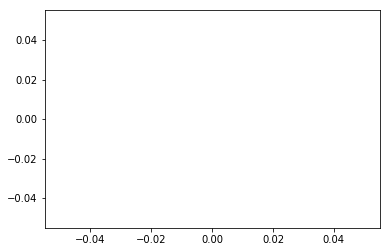

In [400]:
sns.distplot(['time']) # good posts

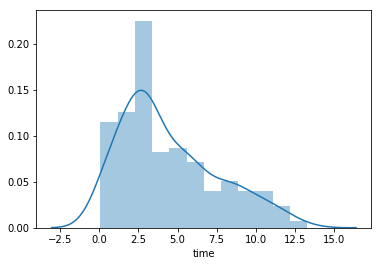

In [410]:
sns.distplot(Z_all_test[ Z_all_test['rating'] == 1]['time'])

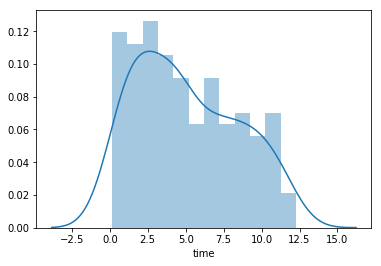

In [411]:
sns.distplot(Z_all_test[ Z_all_test['rating'] == 0]['time'])

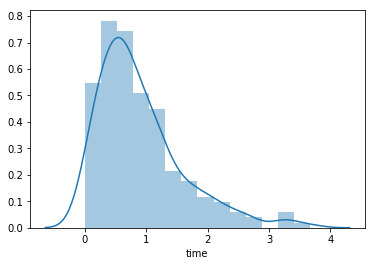

In [412]:
sns.distplot(Y_all_test[Y_all_test['rating'] == 1]['time'])

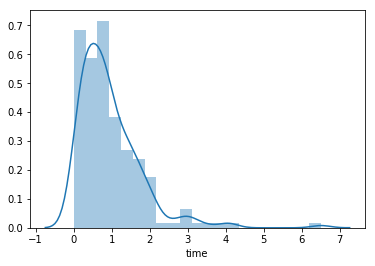

In [413]:
sns.distplot(Y_all_test[Y_all_test['rating'] == 0]['time'])

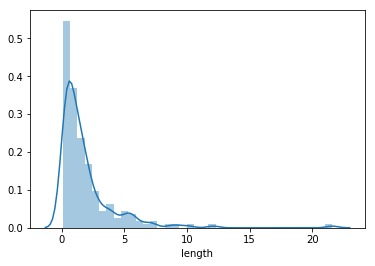

In [414]:
sns.distplot(Y_all_test[Y_all_test['rating'] == 1]['length'])

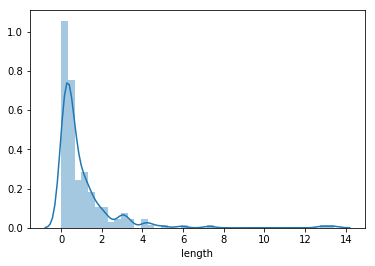

In [415]:
sns.distplot(Y_all_test[Y_all_test['rating'] == 0]['length'])

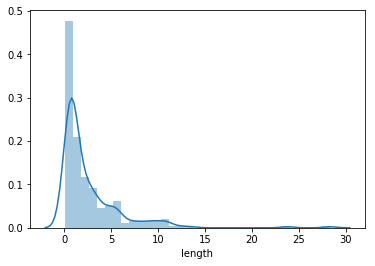

In [416]:
sns.distplot(Z_all_test[Z_all_test['rating'] == 1]['length'])

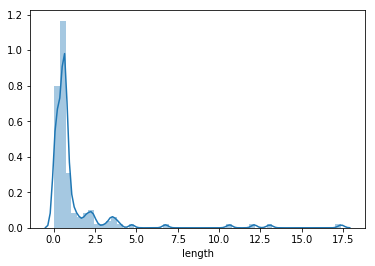

In [417]:
sns.distplot(Z_all_test[Z_all_test['rating'] == 0]['length'])